 **High-Frequency (Crypto price) trading rules using Machine Learning**
 
 Version 2.0 (Technical Indicators(market data))
 
 Momentum strategy + Meta-Labeling



# Contents

1. Financial Data and Bars 
 - Form Bars
 - Summary and plot


2. Getting Signals (Long position only)
 - Momentum strategy (RSI)


3. Labeling with Triple-Barrier Method
 - Form Symmetric Triple Barrier with the signals
 - Binary Labeling (Profit or Loss)


4. Prediction Model

 4.1. Get Features (X)
 - Market data & Technical Analysis
 - *Market Microstructure Features
 - *Macroeconomic Variables
 - *Fundamentals
 - *News Sentiments with NLP
 
 4.2. Feature Engineering
 - Feature Scaling (MinMaxScaler)
 - Dimension Reduction (PCA/ NL Autoencoder)
 
 4.2. Machine Learning Model
 - Hyperparameter tuning
 - AutoML with *autogluon* and select the best model
 - *Feature Importance
 - Results with PnL
 
 
5. Trading
 - *Bet Sizing
 - *Trading Simulation
 
 
5. Results
 - *Cumulative returns, Sharpe Ratio, Drawdown


In [89]:
# https://www.aidoczh.com/autogluon/install.html
# 安装基础数据科学包
# mamba install -y pandas jupyter ipykernel matplotlib scikit-learn -c conda-forge

# # 使用 pip 安装 macOS 专用的 tensorflow
# pip install tensorflow-macos tensorflow-metal

# python -m pip install tensorflow-macos tensorflow-metal "numpy<2.0" ipykernel matplotlib pandas keras scikit-learn seaborn autogluon ta ta-lib


In [5]:
import numpy
import tensorflow as tf

print(f"Numpy version: {numpy.__version__}")
# 应该显示 1.26.x 或类似版本，绝对不能是 2.x.x

print(f"TensorFlow version: {tf.__version__}")
# 现在应该可以正常输出了

import autogluon as ag




Numpy version: 1.26.4
TensorFlow version: 2.16.2


In [6]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from features import triple_barrier as tb, getTA, tautil, microstructure_features as ms
import autogluon as ag

from sklearn import preprocessing
from sklearn.decomposition import PCA 
from features import triple_barrier as tb, getTA, tautil

from scipy.stats import norm, moment

import keras

import warnings
warnings.filterwarnings(action='ignore')

def figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()
    

In [92]:
# De Prado AMFL

# from scipy.stats import norm, moment

# #feature
# from sklearn import preprocessing
# from sklearn.decomposition import PCA 

# #ML
# import autogluon as ag

# deep learning
# import keras

# Technical analysis
# import ta

# Backtesting pyfolio
#import pyfolio as pf


# Financial Data and Bars

## OHLCV Bar + Buy Volume

- Asset: ETH/USD 
- 5 minute data

In [19]:
# df_raw = pd.read_csv('ethusd5min.csv')
# df = df_raw.set_index('timestamp')
# df.index = pd.to_datetime(df.index)

from dataload import data_load_v2

sym = 'ETHUSDT'
data_dir = '/Users/aming/data/ETHUSDT/15m'
start_date_train = '2025-01-01'
end_date_train = '2025-06-01'
start_date_test = '2025-06-01'
end_date_test = '2025-09-01'
timeframe =  '15m'


df = data_load_v2(sym, data_dir=data_dir, start_date=start_date_train, end_date=end_date_test,
                        timeframe=timeframe, file_path=None)

column_mapping = {
    'o':'open',
    'h':'high',
    'l':'low',
    'c':'close',
    'vol':'volume',
    'vol_ccy':'quote_av',
    'trades':'count',
    'close_time':'close_time',
    'taker_buy_volume':'tb_base_av',
    'taker_buy_quote_volume':'tb_quote_av'
}


df = df.rename(columns=column_mapping)

df = df.resample('1H').agg({'open':'first',
                            'high':'max',
                            'low':'min',
                            'close':'last',
                            'volume':'sum',
                            'quote_av':'sum',
                            'count':'sum',
                            'tb_base_av':'sum',
                            'tb_quote_av':'sum',
                            'close_time':'last'
                            })

close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)
buy_volume = pd.to_numeric(df.tb_base_av)

# df.close.plot(figsize=(10,6))

✓ 成功读取 feather: ETHUSDT-15m-2025-01.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-02.feather, 行数: 2688
✓ 成功读取 feather: ETHUSDT-15m-2025-03.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-04.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2025-05.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-06.feather, 行数: 2880
✓ 成功读取 feather: ETHUSDT-15m-2025-07.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-08.feather, 行数: 2976
✓ 成功读取 feather: ETHUSDT-15m-2025-09.feather, 行数: 2880

读取完成: 成功 9 个，失败 0 个

合并后总行数: 26,208
数据时间范围: 2025-01-01 00:00:00 至 2025-09-30 23:45:00



## summary & plots

In [94]:
# plt.figure(figsize=(10,6))
# plt.title('Close Price')
# plt.plot(close)
# plt.savefig('image/close_price.jpg')
# plt.show();

# plt.figure(figsize=(10,6))
# plt.title('Volume')
# plt.plot(volume)
# plt.savefig('image/volume.jpg')
# plt.show();

# plt.figure(figsize=(10,6))
# plt.title('Close Cumulative Return')
# plt.plot(np.cumsum(close.pct_change()))
# plt.savefig('image/closecumreturn.jpg')
# plt.show();

In [ ]:
def get_hourly_vol(close, span0=100):
    """
    计算小时级波动率 (基于 EWM)
    
    Parameters
    ----------
    close : pd.Series
        小时级收盘价
    span0 : int
        EWM 的跨度 (span)。
        如果是小时数据，span=100 大约代表回顾过去 4 天 (100小时) 的波动情况。
    """
    # 1. 计算小时收益率 (r_t = p_t / p_{t-1} - 1)
    # 也就是当前小时相对于上一小时的涨跌幅
    returns = close.pct_change()
    
    # 2. 计算指数加权移动标准差
    vol = returns.ewm(span=span0).std()
    
    return vol

hourly_vol = get_hourly_vol(close, span0=24 * 7)


# 3. CUSUM 采样 (阈值也要适配)
# 阈值设为平均每小时波动的一半，稍微敏感一点
cusum_thresh = hourly_vol.mean() * 0.5 
log_prices = np.log(close)
t_events = tb.cusum_filter(log_prices, threshold=cusum_thresh)

# t_events

pt_sl = [2,1]
# pt_sl = [0.10,0.05]
max_holding = [0,6]

barrier = tb.get_barrier_fast(close,t_events,pt_sl,max_holding=max_holding,target=hourly_vol)
barrier

# for rsi_w in rsi_df.columns:
#    long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
#    enter = long.index
#    pt_sl = [0.10,0.05] # profit-taking, stop-loss target
#    max_holding = [3,0] #[day,hours]
# #    barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
#    barrier = tb.get_barrier_fast(close,enter,pt_sl,max_holding=max_holding,target=None)
#    returns_df['ret_{}'.format(rsi_w)] = barrier.ret



DatetimeIndex(['2025-01-01 01:00:00', '2025-01-01 02:00:00',
               '2025-01-01 04:00:00', '2025-01-01 10:00:00',
               '2025-01-01 11:00:00', '2025-01-01 16:00:00',
               '2025-01-01 19:00:00', '2025-01-02 00:00:00',
               '2025-01-02 02:00:00', '2025-01-02 04:00:00',
               ...
               '2025-09-30 08:00:00', '2025-09-30 09:00:00',
               '2025-09-30 10:00:00', '2025-09-30 14:00:00',
               '2025-09-30 15:00:00', '2025-09-30 16:00:00',
               '2025-09-30 18:00:00', '2025-09-30 19:00:00',
               '2025-09-30 20:00:00', '2025-09-30 21:00:00'],
              dtype='datetime64[ns]', length=3499, freq=None)

In [28]:
pt_sl = [2,1]
# pt_sl = [0.10,0.05]
max_holding = [0,6]

barrier = tb.get_barrier_fast(close,t_events,pt_sl,max_holding=max_holding,target=hourly_vol)
barrier

,exit,price,side,ret
2025-01-01 01:00:00,2025-01-01 07:00:00,3345.82,1.0,0.000006
2025-01-01 02:00:00,2025-01-01 08:00:00,3361.81,1.0,-0.007836
2025-01-01 04:00:00,2025-01-01 10:00:00,3339.94,1.0,-0.004185
2025-01-01 10:00:00,2025-01-01 12:00:00,3325.99,1.0,0.005998
2025-01-01 11:00:00,2025-01-01 17:00:00,3340.06,1.0,0.000853
...,...,...,...,...
2025-09-30 16:00:00,2025-09-30 19:00:00,4097.86,1.0,0.014685
2025-09-30 18:00:00,2025-09-30 19:00:00,4114.89,1.0,0.010538
2025-09-30 19:00:00,NaT,4158.48,1.0,0.000000
2025-09-30 20:00:00,2025-09-30 21:00:00,4194.12,1.0,-0.010520


In [32]:
# ========================================
# 参数网格搜索
# ========================================
import itertools
from datetime import datetime

# 定义参数搜索空间
param_grid = {
    'vol_span': [24*1, 24*2, 24*3, 24*5, 24*7],  # 3天, 5天, 7天, 10天, 14天
    'cusum_multiplier': [0.3, 0.5, 0.7, 1.0],  # CUSUM阈值倍数
    'pt': [1.5, 2.0, 2.5, 3.0],  # 止盈倍数
    'sl': [0.5, 1.0, 1.5, 2.0],  # 止损倍数
    'max_holding_hours': [4, 6, 12, 24, 48]  # 最大持仓时间（小时）
}

print(f"开始时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

# 存储结果
results_list = []

# 遍历所有参数组合
total_combinations = np.prod([len(v) for v in param_grid.values()])
counter = 0

for vol_span in param_grid['vol_span']:
    for cusum_mult in param_grid['cusum_multiplier']:
        for pt in param_grid['pt']:
            for sl in param_grid['sl']:
                for max_h in param_grid['max_holding_hours']:
                    counter += 1
                    
                    try:
                        # 计算波动率
                        hourly_vol = get_hourly_vol(close, span0=vol_span)
                        
                        # CUSUM采样
                        cusum_thresh = hourly_vol.mean() * cusum_mult
                        log_prices = np.log(close)
                        t_events = tb.cusum_filter(log_prices, threshold=cusum_thresh)
                        
                        # 跳过事件太少的情况
                        if len(t_events) < 10:
                            continue
                        
                        # Triple Barrier
                        pt_sl = [pt, sl]
                        max_holding = [0, max_h]
                        barrier = tb.get_barrier_fast(close, t_events, pt_sl, 
                                                       max_holding=max_holding, 
                                                       target=hourly_vol)
                        
                        # 计算统计指标
                        n_events = len(t_events)
                        n_valid_trades = len(barrier.dropna(subset=['exit']))
                        total_return = barrier['ret'].sum()
                        cum_return = barrier['ret'].cumsum().iloc[-1] if len(barrier) > 0 else 0
                        mean_return = barrier['ret'].mean()
                        std_return = barrier['ret'].std()
                        sharpe = mean_return / std_return * np.sqrt(24*365) if std_return > 0 else 0  # 年化Sharpe
                        win_rate = (barrier['ret'] > 0).mean() if len(barrier) > 0 else 0
                        max_drawdown = (barrier['ret'].cumsum() - barrier['ret'].cumsum().cummax()).min()
                        
                        # 存储结果
                        result = {
                            'vol_span': vol_span,
                            'vol_span_days': vol_span / 24,
                            'cusum_multiplier': cusum_mult,
                            'profit_taking': pt,
                            'stop_loss': sl,
                            'max_holding_hours': max_h,
                            'n_events': n_events,
                            'n_valid_trades': n_valid_trades,
                            'total_return': total_return,
                            'cum_return': cum_return,
                            'mean_return': mean_return,
                            'std_return': std_return,
                            'sharpe_ratio': sharpe,
                            'win_rate': win_rate,
                            'max_drawdown': max_drawdown,
                            'avg_vol': hourly_vol.mean()
                        }
                        results_list.append(result)
                        
                    except Exception as e:
                        print(f"错误 - 参数组合 {counter}/{total_combinations}: {e}")
                        continue
                    
                    # 进度显示
                    if counter % 100 == 0:
                        print(f"进度: {counter}/{total_combinations} ({counter/total_combinations*100:.1f}%)")

# 转换为DataFrame
results_df = pd.DataFrame(results_list)

print("=" * 60)
print(f"完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"成功测试: {len(results_df)} 个参数组合")
print("=" * 60)

# 显示前10个最佳结果（按Sharpe比率排序）
print("\n前10个最佳参数组合（按Sharpe比率）:")
print(results_df.nlargest(10, 'sharpe_ratio')[['vol_span_days', 'cusum_multiplier', 'profit_taking', 
                                                  'stop_loss', 'max_holding_hours', 'sharpe_ratio', 
                                                  'win_rate', 'n_valid_trades', 'cum_return']])

# 保存所有结果
results_df.to_csv('parameter_search_results.csv', index=False)
print("\n所有结果已保存到: parameter_search_results.csv")

results_df.head(20)


开始时间: 2026-01-24 14:02:25
进度: 100/1600 (6.2%)
进度: 200/1600 (12.5%)
进度: 300/1600 (18.8%)
进度: 400/1600 (25.0%)
进度: 500/1600 (31.2%)
进度: 600/1600 (37.5%)
进度: 700/1600 (43.8%)
进度: 800/1600 (50.0%)
进度: 900/1600 (56.2%)
进度: 1000/1600 (62.5%)
进度: 1100/1600 (68.8%)
进度: 1200/1600 (75.0%)
进度: 1300/1600 (81.2%)
进度: 1400/1600 (87.5%)
进度: 1500/1600 (93.8%)
进度: 1600/1600 (100.0%)
完成时间: 2026-01-24 14:04:18
成功测试: 1600 个参数组合

前10个最佳参数组合（按Sharpe比率）:
     vol_span_days  cusum_multiplier  profit_taking  stop_loss  \
284            1.0               1.0            2.5        0.5   
604            2.0               1.0            2.5        0.5   
283            1.0               1.0            2.5        0.5   
264            1.0               1.0            2.0        0.5   
603            2.0               1.0            2.5        0.5   
282            1.0               1.0            2.5        0.5   
44             1.0               0.3            2.5        0.5   
24             1.0               0.3

,vol_span,vol_span_days,cusum_multiplier,profit_taking,stop_loss,max_holding_hours,n_events,n_valid_trades,total_return,cum_return,mean_return,std_return,sharpe_ratio,win_rate,max_drawdown,avg_vol
0,24,1.0,0.3,1.5,0.5,4,4515,4514,0.223746,0.223746,0.000050,0.012466,0.372066,0.428128,-1.837486,0.007044
1,24,1.0,0.3,1.5,0.5,6,4515,4514,0.304755,0.304755,0.000067,0.013279,0.475769,0.397342,-2.061987,0.007044
2,24,1.0,0.3,1.5,0.5,12,4515,4514,0.833705,0.833705,0.000185,0.014129,1.223171,0.372536,-2.104035,0.007044
3,24,1.0,0.3,1.5,0.5,24,4515,4514,1.065746,1.065746,0.000236,0.014336,1.541020,0.365891,-2.012950,0.007044
4,24,1.0,0.3,1.5,0.5,48,4515,4514,1.136481,1.136481,0.000252,0.014374,1.639022,0.365227,-2.012950,0.007044
5,24,1.0,0.3,1.5,1.0,4,4515,4513,0.283936,0.283936,0.000063,0.013531,0.434983,0.492580,-2.166226,0.007044
6,24,1.0,0.3,1.5,1.0,6,4515,4513,0.162575,0.162575,0.000036,0.014772,0.228146,0.476412,-2.648788,0.007044
7,24,1.0,0.3,1.5,1.0,12,4515,4513,0.595192,0.595192,0.000132,0.016305,0.756695,0.462680,-2.878381,0.007044
8,24,1.0,0.3,1.5,1.0,24,4515,4513,0.837094,0.837094,0.000185,0.016759,1.035453,0.452713,-2.962005,0.007044
9,24,1.0,0.3,1.5,1.0,48,4515,4513,0.814738,0.814738,0.000180,0.016855,1.002020,0.451606,-3.047985,0.007044


In [34]:
# # ========================================
# # 参数搜索结果分析和可视化
# # ========================================
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1. 基础统计
# print("=" * 60)
# print("参数搜索结果统计摘要")
# print("=" * 60)
# print(f"\nSharpe比率统计:")
# print(results_df['sharpe_ratio'].describe())
# print(f"\n胜率统计:")
# print(results_df['win_rate'].describe())
# print(f"\n累计收益统计:")
# print(results_df['cum_return'].describe())

# # 2. 找出最佳参数组合
# best_sharpe = results_df.loc[results_df['sharpe_ratio'].idxmax()]
# best_return = results_df.loc[results_df['cum_return'].idxmax()]
# best_winrate = results_df.loc[results_df['win_rate'].idxmax()]

# print("\n" + "=" * 60)
# print("最佳参数组合")
# print("=" * 60)
# print("\n【最高Sharpe比率】:")
# print(f"  波动率窗口: {best_sharpe['vol_span_days']:.1f}天")
# print(f"  CUSUM倍数: {best_sharpe['cusum_multiplier']}")
# print(f"  止盈倍数: {best_sharpe['profit_taking']}")
# print(f"  止损倍数: {best_sharpe['stop_loss']}")
# print(f"  最大持仓: {best_sharpe['max_holding_hours']}小时")
# print(f"  Sharpe比率: {best_sharpe['sharpe_ratio']:.2f}")
# print(f"  胜率: {best_sharpe['win_rate']:.2%}")
# print(f"  累计收益: {best_sharpe['cum_return']:.4f}")
# print(f"  交易次数: {best_sharpe['n_valid_trades']:.0f}")

# print("\n【最高累计收益】:")
# print(f"  波动率窗口: {best_return['vol_span_days']:.1f}天")
# print(f"  CUSUM倍数: {best_return['cusum_multiplier']}")
# print(f"  止盈倍数: {best_return['profit_taking']}")
# print(f"  止损倍数: {best_return['stop_loss']}")
# print(f"  最大持仓: {best_return['max_holding_hours']}小时")
# print(f"  Sharpe比率: {best_return['sharpe_ratio']:.2f}")
# print(f"  胜率: {best_return['win_rate']:.2%}")
# print(f"  累计收益: {best_return['cum_return']:.4f}")
# print(f"  交易次数: {best_return['n_valid_trades']:.0f}")

# # 3. 可视化分析
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# fig.suptitle('参数网格搜索结果分析', fontsize=16, fontweight='bold')

# # 3.1 Sharpe比率分布
# axes[0, 0].hist(results_df['sharpe_ratio'], bins=50, alpha=0.7, color='blue', edgecolor='black')
# axes[0, 0].axvline(results_df['sharpe_ratio'].mean(), color='red', linestyle='--', label=f'均值: {results_df["sharpe_ratio"].mean():.2f}')
# axes[0, 0].set_xlabel('Sharpe比率')
# axes[0, 0].set_ylabel('频数')
# axes[0, 0].set_title('Sharpe比率分布')
# axes[0, 0].legend()
# axes[0, 0].grid(alpha=0.3)

# # 3.2 累计收益 vs Sharpe比率
# scatter = axes[0, 1].scatter(results_df['cum_return'], results_df['sharpe_ratio'], 
#                             c=results_df['win_rate'], cmap='RdYlGn', alpha=0.6, s=30)
# axes[0, 1].set_xlabel('累计收益')
# axes[0, 1].set_ylabel('Sharpe比率')
# axes[0, 1].set_title('收益 vs Sharpe (颜色=胜率)')
# plt.colorbar(scatter, ax=axes[0, 1], label='胜率')
# axes[0, 1].grid(alpha=0.3)

# # 3.3 胜率分布
# axes[0, 2].hist(results_df['win_rate'], bins=30, alpha=0.7, color='green', edgecolor='black')
# axes[0, 2].axvline(results_df['win_rate'].mean(), color='red', linestyle='--', label=f'均值: {results_df["win_rate"].mean():.2%}')
# axes[0, 2].set_xlabel('胜率')
# axes[0, 2].set_ylabel('频数')
# axes[0, 2].set_title('胜率分布')
# axes[0, 2].legend()
# axes[0, 2].grid(alpha=0.3)

# # 3.4 各参数对Sharpe比率的影响（箱线图）
# param_names = ['vol_span_days', 'cusum_multiplier', 'profit_taking', 'stop_loss', 'max_holding_hours']
# axes[1, 0].boxplot([results_df.groupby('vol_span_days')['sharpe_ratio'].mean(),
#                      results_df.groupby('cusum_multiplier')['sharpe_ratio'].mean(),
#                      results_df.groupby('profit_taking')['sharpe_ratio'].mean(),
#                      results_df.groupby('stop_loss')['sharpe_ratio'].mean(),
#                      results_df.groupby('max_holding_hours')['sharpe_ratio'].mean()],
#                     labels=['Vol窗口', 'CUSUM倍数', '止盈倍数', '止损倍数', '持仓时间'])
# axes[1, 0].set_ylabel('平均Sharpe比率')
# axes[1, 0].set_title('参数对Sharpe的影响')
# axes[1, 0].tick_params(axis='x', rotation=45)
# axes[1, 0].grid(alpha=0.3)

# # 3.5 止盈止损比例热图
# pivot_ptsl = results_df.groupby(['profit_taking', 'stop_loss'])['sharpe_ratio'].mean().unstack()
# sns.heatmap(pivot_ptsl, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1, 1], 
#             cbar_kws={'label': 'Sharpe比率'})
# axes[1, 1].set_xlabel('止损倍数')
# axes[1, 1].set_ylabel('止盈倍数')
# axes[1, 1].set_title('止盈/止损组合热图')

# # 3.6 交易次数 vs Sharpe比率
# axes[1, 2].scatter(results_df['n_valid_trades'], results_df['sharpe_ratio'], 
#                    alpha=0.5, c=results_df['cum_return'], cmap='viridis', s=30)
# axes[1, 2].set_xlabel('有效交易次数')
# axes[1, 2].set_ylabel('Sharpe比率')
# axes[1, 2].set_title('交易次数 vs Sharpe (颜色=累计收益)')
# axes[1, 2].grid(alpha=0.3)

# plt.tight_layout()
# plt.savefig('parameter_search_analysis.png', dpi=150, bbox_inches='tight')
# plt.show()

# print("\n图表已保存到: parameter_search_analysis.png")


使用最佳参数重新计算
波动率窗口: 1.0天 (24小时)
CUSUM倍数: 1
止盈倍数: 2.5
止损倍数: 0.5
最大持仓: 48小时

触发事件数: 2152
有效交易数: 2152
平均小时波动率: 0.7044%
CUSUM阈值: 0.007044


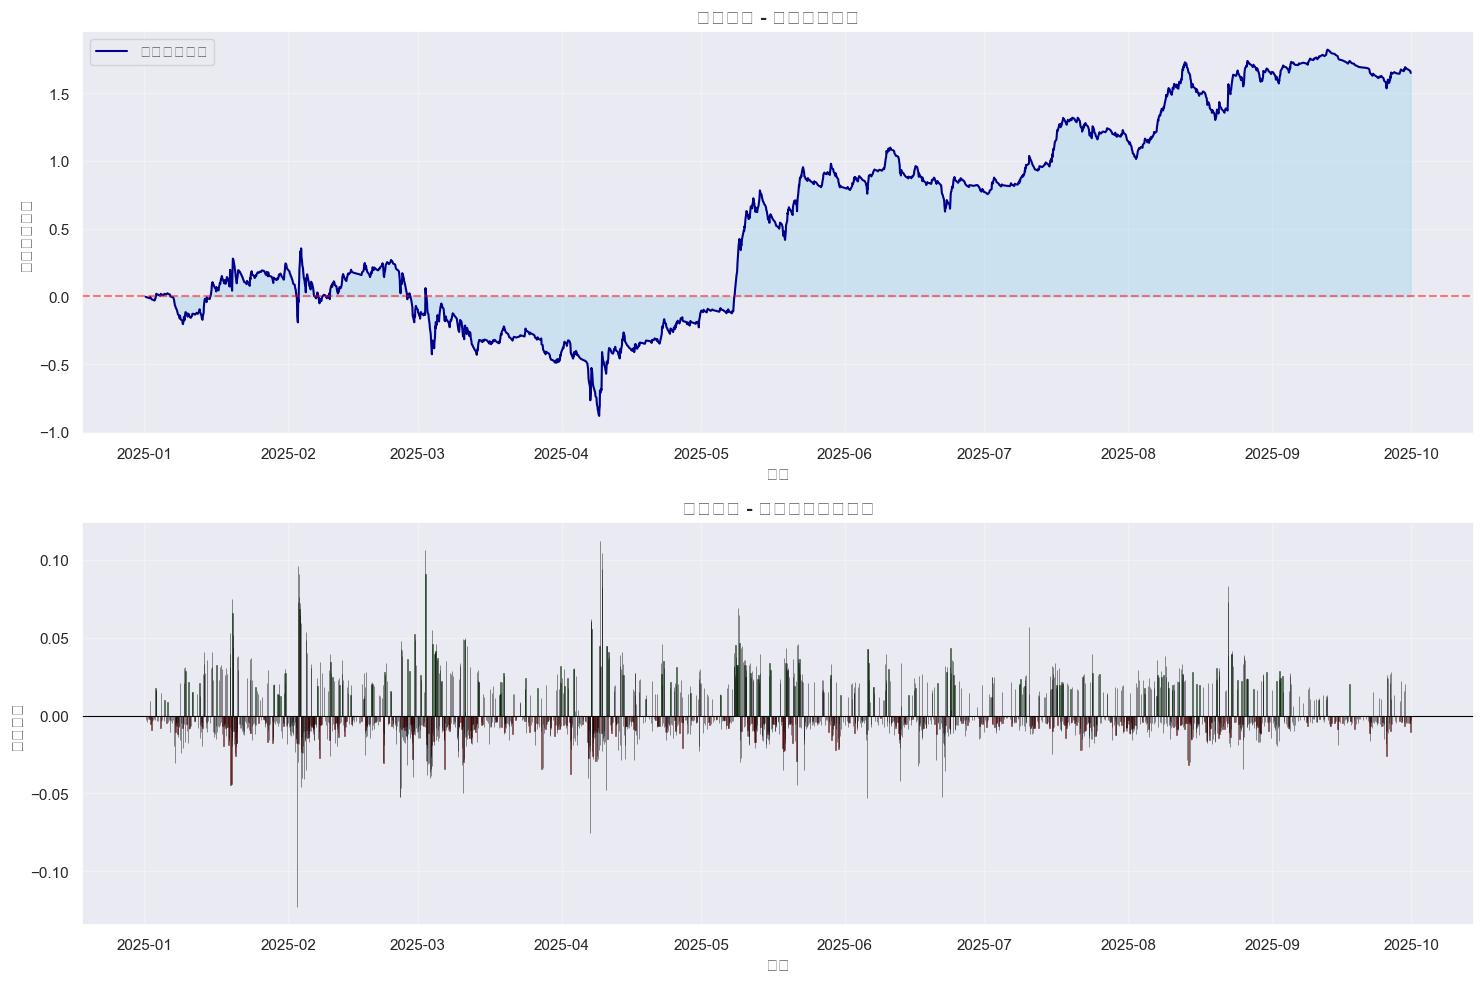


图表已保存到: best_params_performance.png

Barrier数据预览:


,exit,price,side,ret
2025-01-01 08:00:00,2025-01-01 10:00:00,3335.57,1.0,-0.002876
2025-01-01 15:00:00,2025-01-01 16:00:00,3352.07,1.0,-0.004284
2025-01-01 21:00:00,2025-01-01 22:00:00,3367.60,1.0,-0.002096
2025-01-02 00:00:00,2025-01-02 01:00:00,3389.12,1.0,-0.001804
2025-01-02 04:00:00,2025-01-02 06:00:00,3417.81,1.0,-0.002229
2025-01-02 08:00:00,2025-01-02 11:00:00,3437.99,1.0,0.009432
2025-01-02 09:00:00,2025-01-02 17:00:00,3467.87,1.0,-0.005262
2025-01-02 14:00:00,2025-01-02 15:00:00,3494.53,1.0,-0.009133
2025-01-02 15:00:00,2025-01-02 17:00:00,3462.76,1.0,-0.003787
2025-01-02 22:00:00,2025-01-03 08:00:00,3440.00,1.0,-0.003200


In [37]:
# ========================================
# 使用最佳参数重新计算barrier
# ========================================

# 选择要使用的最佳参数（可根据需要选择Sharpe最高或收益最高）
selected_params = {
    'vol_span': 24,
    'vol_span_days': 1,
    'cusum_multiplier': 1,
    'profit_taking': 2.5,
    'stop_loss': 0.5,
    'max_holding_hours': 48
}  # 或者 best_return

print("=" * 60)
print("使用最佳参数重新计算")
print("=" * 60)
print(f"波动率窗口: {selected_params['vol_span_days']:.1f}天 ({int(selected_params['vol_span'])}小时)")
print(f"CUSUM倍数: {selected_params['cusum_multiplier']}")
print(f"止盈倍数: {selected_params['profit_taking']}")
print(f"止损倍数: {selected_params['stop_loss']}")
print(f"最大持仓: {selected_params['max_holding_hours']}小时")
print("=" * 60)

# 使用最佳参数重新计算
hourly_vol = get_hourly_vol(close, span0=int(selected_params['vol_span']))

cusum_thresh = hourly_vol.mean() * selected_params['cusum_multiplier']
log_prices = np.log(close)
t_events = tb.cusum_filter(log_prices, threshold=cusum_thresh)

pt_sl = [selected_params['profit_taking'], selected_params['stop_loss']]
max_holding = [0, int(selected_params['max_holding_hours'])]

barrier = tb.get_barrier_fast(close, t_events, pt_sl, 
                               max_holding=max_holding, 
                               target=hourly_vol)

print(f"\n触发事件数: {len(t_events)}")
print(f"有效交易数: {len(barrier.dropna(subset=['exit']))}")
print(f"平均小时波动率: {hourly_vol.mean():.4%}")
print(f"CUSUM阈值: {cusum_thresh:.6f}")

# 绘制cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 累计收益曲线
cumret = barrier['ret'].cumsum()
axes[0].plot(cumret, linewidth=1.5, color='darkblue', label='累计对数收益')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].fill_between(cumret.index, cumret, 0, alpha=0.3, color='skyblue')
axes[0].set_title('最佳参数 - 累计收益曲线', fontsize=14, fontweight='bold')
axes[0].set_xlabel('时间')
axes[0].set_ylabel('累计对数收益')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 每次交易的收益
axes[1].bar(barrier.index, barrier['ret'], width=pd.Timedelta(hours=1), 
            color=['green' if x > 0 else 'red' for x in barrier['ret']], 
            alpha=0.6, edgecolor='black', linewidth=0.5)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_title('最佳参数 - 单次交易收益分布', fontsize=14, fontweight='bold')
axes[1].set_xlabel('时间')
axes[1].set_ylabel('单次收益')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('best_params_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n图表已保存到: best_params_performance.png")

# 显示barrier数据
print(f"\nBarrier数据预览:")
barrier.head(10)


# Getting Signals

 
 I considered only long (up-trend) side.
 
 It is not difficult to do the other side.

## Momentum strategy

For example, let's see the RSI(relative strength index), which is the momentum indicator

I made the threshold to choose when to long or short. 

In [16]:
# windows = np.arange(10,210,10)
# rsi_df = pd.DataFrame(index=df.index)
# # for w in windows:
# #     rsi_df['rsi_{}'.format(w)] = tautil.get_rsi(close, w)
# rsi_df = tautil.get_my_rsi(close, windows)
# rsi_df.dropna(inplace=True)

# rsi_df.head(5)

rsi(14) is often adopted in daily data.

Here is 5 minutes data.

And we have to consider this is crypto data which is far more volatile.


In [98]:
# # long signals

# for i in rsi_df.columns:
#     sc = rsi_df[i].copy()
#     plt.figure(figsize=(15,4))
#     plt.plot(close.loc[sc.index], linewidth=0.8,alpha=0.6)
#     plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap='gray_r', s = 10, alpha=0.3, vmin=0,vmax=1)
#     plt.colorbar()
#     plt.title('{}'.format(i))
#     plt.show()

# Labeling with Triple-Barrier Method
 ## Form Symmetric Triple Barrier with signals
 

Below is for testing various windows.

In [ ]:
# returns_df = pd.DataFrame()

# for rsi_w in rsi_df.columns:
#    long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
#    enter = long.index
#    pt_sl = [0.10,0.05] # profit-taking, stop-loss target
#    max_holding = [3,0] #[day,hours]
# #    barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
#    barrier = tb.get_barrier_fast(close,enter,pt_sl,max_holding=max_holding,target=None)
#    returns_df['ret_{}'.format(rsi_w)] = barrier.ret

In [ ]:
# returns_df = pd.DataFrame()
# returns_df['ret_{}'.format(rsi_w)] = barrier.ret

In [100]:
# for r in returns_df.columns:
#    ret = returns_df[r].dropna()
#    # Intended symmetric returns
#    plt.figure(figsize=(10,6))
#    plt.title('Symmetric returns of Primary Model')
#    plt.bar(ret.index, ret.dropna(),linewidth=0)
#    #plt.savefig('return_of_1stmodel.jpg')
#    plt.show();

In [39]:
# returns_df.cumsum()

For simplicity, I will choose rsi window = 100 for this asset and interval.

You can use other methods, for example combining with MACD.


In [38]:
# rsi_w = 'rsi_100'

# # rsi_df[rsi_df[rsi_w]!=1]
# long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
# enter = long.index
# pt_sl = [0.10,0.05] # profit-taking, stop-loss target
# max_holding = [3,0] #[day,hours]
# enter

# import time

# # start_time_1 = time.time()
# # barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
# # end_time_1 = time.time()

# # elapsed_time_1 = end_time_1 - start_time_1
# # print(elapsed_time_1)

# start_time_2 = time.time()
# barrier2 = tb.get_barrier_fast(close,enter,pt_sl,max_holding=max_holding,target=None)
# end_time_2 = time.time()

# elapsed_time_2 = end_time_2 - start_time_2
# print(elapsed_time_2)

# barrier

# # barrier_pd = pd.concat([barrier,barrier2],axis=1)
# # barrier_pd.describe()


In [40]:
barrier

,exit,price,side,ret
2025-01-01 08:00:00,2025-01-01 10:00:00,3335.57,1.0,-0.002876
2025-01-01 15:00:00,2025-01-01 16:00:00,3352.07,1.0,-0.004284
2025-01-01 21:00:00,2025-01-01 22:00:00,3367.60,1.0,-0.002096
2025-01-02 00:00:00,2025-01-02 01:00:00,3389.12,1.0,-0.001804
2025-01-02 04:00:00,2025-01-02 06:00:00,3417.81,1.0,-0.002229
...,...,...,...,...
2025-09-30 09:00:00,2025-09-30 15:00:00,4139.25,1.0,-0.005125
2025-09-30 15:00:00,2025-09-30 16:00:00,4118.09,1.0,-0.004925
2025-09-30 19:00:00,2025-09-30 22:00:00,4158.48,1.0,-0.005017
2025-09-30 20:00:00,2025-09-30 21:00:00,4194.12,1.0,-0.010520


Make triple barrier using long signals, profit-taking/stop-loss target returns (must be symmetric), and maximum holding period.

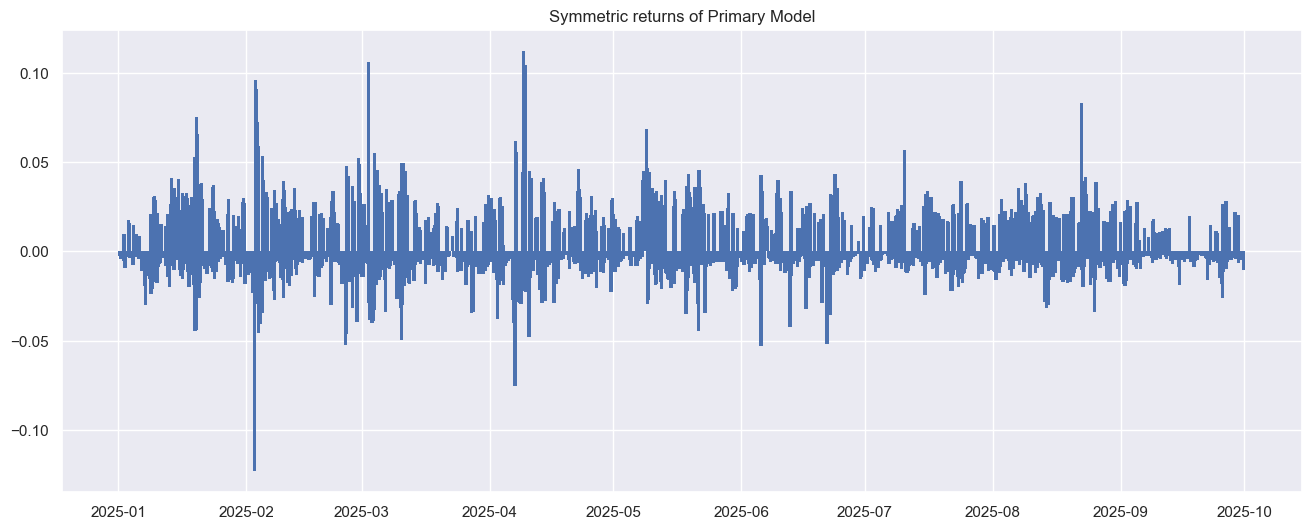

In [41]:
ret = barrier.ret
plt.figure(figsize=(16,6))
plt.title('Symmetric returns of Primary Model')
plt.bar(ret.index, ret.dropna(),linewidth=0)
plt.savefig('image/returns_of_1stmodel.jpg')
plt.show();

You can see the symmetric returns, except for those who exceed max holding periods. 

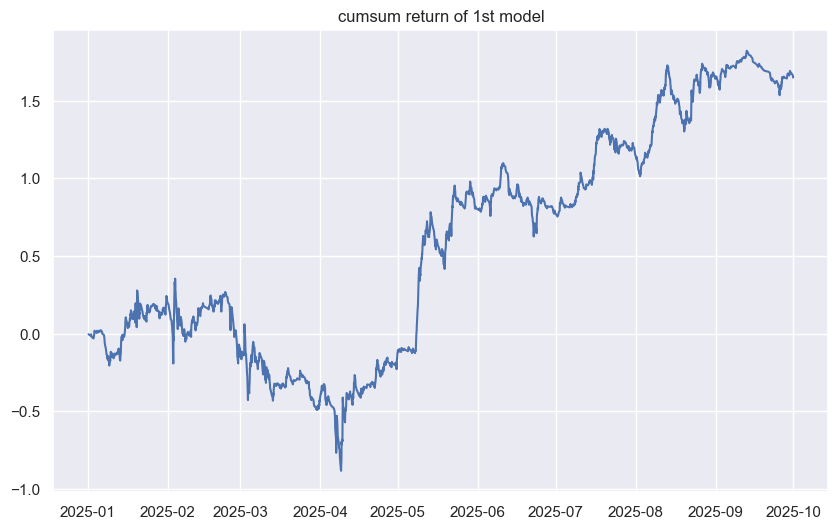

In [43]:
plt.figure(figsize=(10,6))
plt.title('cumsum return of 1st model')
plt.savefig('image/cumsum_return_1stmodel.jpg')
plt.plot(ret.cumsum())
plt.show()

In [46]:
t_events

DatetimeIndex(['2025-01-01 08:00:00', '2025-01-01 15:00:00',
               '2025-01-01 21:00:00', '2025-01-02 00:00:00',
               '2025-01-02 04:00:00', '2025-01-02 08:00:00',
               '2025-01-02 09:00:00', '2025-01-02 14:00:00',
               '2025-01-02 15:00:00', '2025-01-02 22:00:00',
               ...
               '2025-09-29 13:00:00', '2025-09-29 16:00:00',
               '2025-09-29 19:00:00', '2025-09-29 20:00:00',
               '2025-09-30 04:00:00', '2025-09-30 09:00:00',
               '2025-09-30 15:00:00', '2025-09-30 19:00:00',
               '2025-09-30 20:00:00', '2025-09-30 21:00:00'],
              dtype='datetime64[ns]', length=2152, freq=None)

## Binary Labeling (Profit or Loss)

In [47]:
first_model = pd.DataFrame()
first_model['y_pred'] = t_events
first_model['y_true'] = np.sign(t_events*barrier.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

TypeError: cannot perform __mul__ with this index type: DatetimeArray

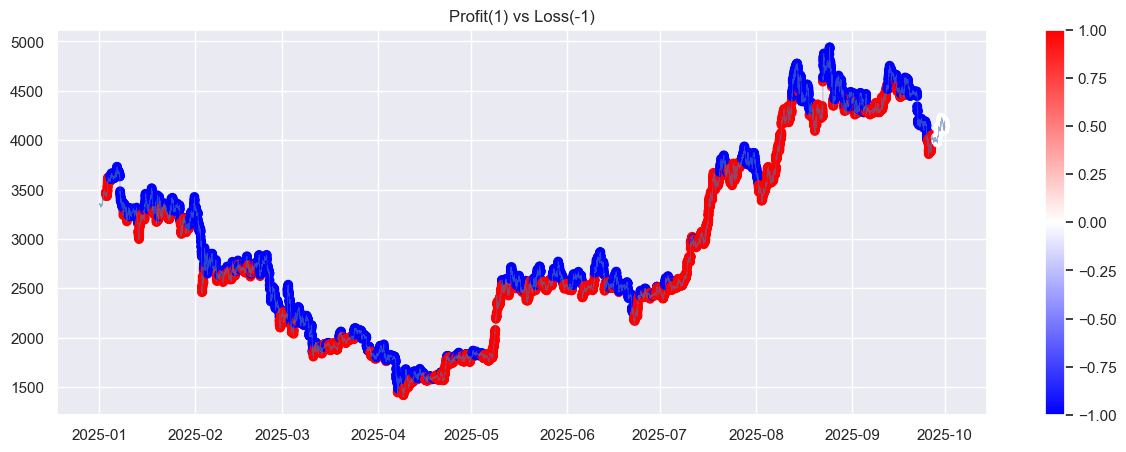

In [108]:
sc = y_true1
title = 'Profit(1) vs Loss(-1)'
figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5))

In [109]:
pnllabel = y_true1.loc[y_true1!=0]
pnllabel.value_counts()

y_true
-1.0    6622
 1.0    6411
Name: count, dtype: int64

In [110]:
print('Probability of winning: ',pnllabel.value_counts().values[0] / pnllabel.value_counts().values.sum())

Probability of winning:  0.5080948361850687


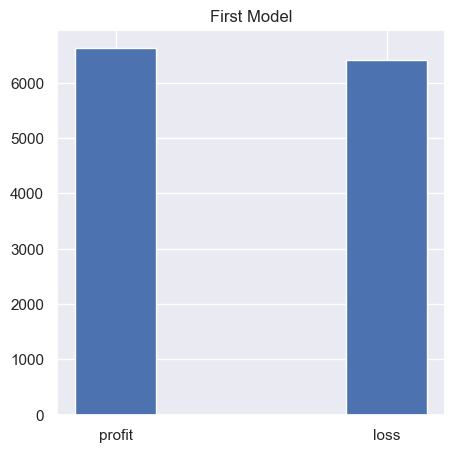

In [111]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],pnllabel.value_counts(), width=0.3)
plt.title('First Model')
plt.savefig('image/pnl_first_model.jpg')
plt.show()

# Prediction Model

For feature engineering we have to split train and test periods.

In [112]:
y = pnllabel.copy().rename('y').to_frame()
train_y = y.loc[:end_date_train,:]
test_y = y.loc[start_date_test:,:]
y
train_y

,y
open_time,
2025-01-03 02:00:00,1.0
2025-01-03 02:15:00,1.0
2025-01-03 03:00:00,1.0
2025-01-03 03:15:00,1.0
2025-01-03 03:30:00,1.0
...,...
2025-06-01 21:45:00,1.0
2025-06-01 22:00:00,1.0
2025-06-01 22:30:00,1.0


 ## Get Features (X)
 
 ###  Market data

Market
- Techincal indicators with market data


In [113]:
# df_ohlcv = pd.DataFrame([open,high,low,close,volume]).T
df_ = df
of = buy_volume - (volume-buy_volume)
df_

,open,high,low,close,volume,quote_av,count,close_time,tb_base_av,tb_quote_av
open_time,,,,,,,,,,
2025-01-01 00:00:00,3336.58,3348.47,3334.76,3347.40,11849.907,3.959481e+07,30079,1735690499999,7513.408,2.510607e+07
2025-01-01 00:15:00,3347.41,3353.00,3345.99,3348.62,13400.864,4.488825e+07,30217,1735691399999,7352.137,2.462981e+07
2025-01-01 00:30:00,3348.63,3360.47,3348.03,3355.36,28098.106,9.427517e+07,36044,1735692299999,17922.882,6.013062e+07
2025-01-01 00:45:00,3355.36,3364.50,3353.11,3362.90,14978.352,5.032034e+07,31919,1735693199999,9098.811,3.056924e+07
2025-01-01 01:00:00,3362.89,3365.32,3354.00,3359.62,13083.658,4.395107e+07,28529,1735694099999,5268.456,1.769978e+07
...,...,...,...,...,...,...,...,...,...,...
2025-09-30 22:45:00,4140.93,4145.99,4128.00,4137.67,29562.740,1.223017e+08,45553,1759273199999,15880.898,6.570344e+07
2025-09-30 23:00:00,4137.68,4138.50,4113.04,4126.21,78697.756,3.243879e+08,66886,1759274099999,30822.553,1.270154e+08
2025-09-30 23:15:00,4126.20,4138.57,4122.83,4135.45,29020.296,1.199121e+08,34618,1759274999999,17259.026,7.131649e+07


In [114]:
mts= [5,10,30,60,100] #multipliers
TA = getTA.get_ta_windows(df_,mts)

In [115]:
TA

,aroon_125,aroon_1500,aroon_250,aroon_2500,aroon_750,dpo_100,dpo_1200,dpo_200,dpo_2000,dpo_600,...,rsi_140,rsi_1400,rsi_420,rsi_70,rsi_840,stoch_diff_1400_3,stoch_diff_140_3,stoch_diff_420_3,stoch_diff_70_3,stoch_diff_840_3
open_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30 22:45:00,-51.2,-48.666667,58.0,-48.32,54.933333,-26.2640,-37.626008,74.62170,123.683500,-55.818067,...,50.839298,49.416972,49.914009,49.285715,49.297962,-0.775855,-3.815345,-2.382429,-5.528060,-0.936088
2025-09-30 23:00:00,-51.2,-48.666667,58.0,-48.32,54.933333,-21.7413,-38.268217,72.76805,125.648900,-51.070450,...,50.274864,49.366975,49.733823,48.253611,49.211220,-1.063450,-5.229620,-2.669440,-7.577205,-1.838780
2025-09-30 23:15:00,-51.2,-48.666667,58.0,-48.32,54.933333,-9.4854,-30.097108,70.64305,124.165525,-50.231000,...,50.719180,49.408275,49.880051,49.125061,49.283257,0.285157,1.402289,0.715793,2.031779,0.693435


First I chose default windows (daily) for each technical indicators/

This is 5 minute data and in first model, I chose rsi_100 instead of rsi_14.

So I will muliply some numbers to the windows. [10,30,50,100]

In [116]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_av', 'count',
       'close_time', 'tb_base_av', 'tb_quote_av'],
      dtype='object')

In [117]:
mkt = TA.copy()

for i in [1,5,10,30]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [5,30,60,100]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))

for i in [5,10,30]:
    ms_features = ms.get_microstructure_features(df, window=i)
    # print(ms_features.isna().mean().sort_values(ascending=False).head(20))
    mkt = mkt.join(ms_features)

for i in [5,30,60,100]:
    stationary_features = tautil.get_stationary_ta_window_0(df, mt=i, fillna=True)
    mkt = mkt.join(stationary_features)

# mkt = mkt.dropna()
mkt

corr = mkt.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [118]:
mkt

,aroon_125,aroon_1500,aroon_250,aroon_2500,aroon_750,dpo_100,dpo_1200,dpo_200,dpo_2000,dpo_600,...,momentum_rsi_1500,momentum_tsi_2500_1500,momentum_stoch_1500,momentum_stoch_signal_1500,momentum_wr_1500,momentum_ao_500_3500,momentum_roc_1000,momentum_ppo_2500_1000_9,momentum_ppo_signal_2500_1000_9,momentum_ppo_hist_2500_1000_9
open_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,0.000000,92.195478,92.195478,-7.804522,0.000000,0.000000,0.000000,0.000000,0.000000
2025-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,75.986842,84.091160,-24.013158,0.000000,0.000000,0.000044,0.000009,0.000035
2025-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,80.124465,82.768928,-19.875535,0.000000,0.000000,0.000329,0.000073,0.000256
2025-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,94.620040,83.577116,-5.379960,0.000000,0.000000,0.000882,0.000235,0.000648
2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,82.519301,99.999427,81.348168,85.364224,-18.651832,0.000000,0.000000,0.001317,0.000451,0.000866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30 22:45:00,-51.2,-48.666667,58.0,-48.32,54.933333,-26.2640,-37.626008,74.62170,123.683500,-55.818067,...,49.460308,-1.218091,38.468194,39.244049,-61.531806,-311.089839,-7.309014,-2.428364,-2.434744,0.006380
2025-09-30 23:00:00,-51.2,-48.666667,58.0,-48.32,54.933333,-21.7413,-38.268217,72.76805,125.648900,-51.070450,...,49.413915,-1.218318,37.071655,38.135104,-62.928345,-310.389060,-7.533217,-2.427506,-2.433296,0.005790
2025-09-30 23:15:00,-51.2,-48.666667,58.0,-48.32,54.933333,-9.4854,-30.097108,70.64305,124.165525,-50.231000,...,49.452169,-1.218427,38.197660,37.912503,-61.802340,-309.725029,-7.422415,-2.426383,-2.431914,0.005531


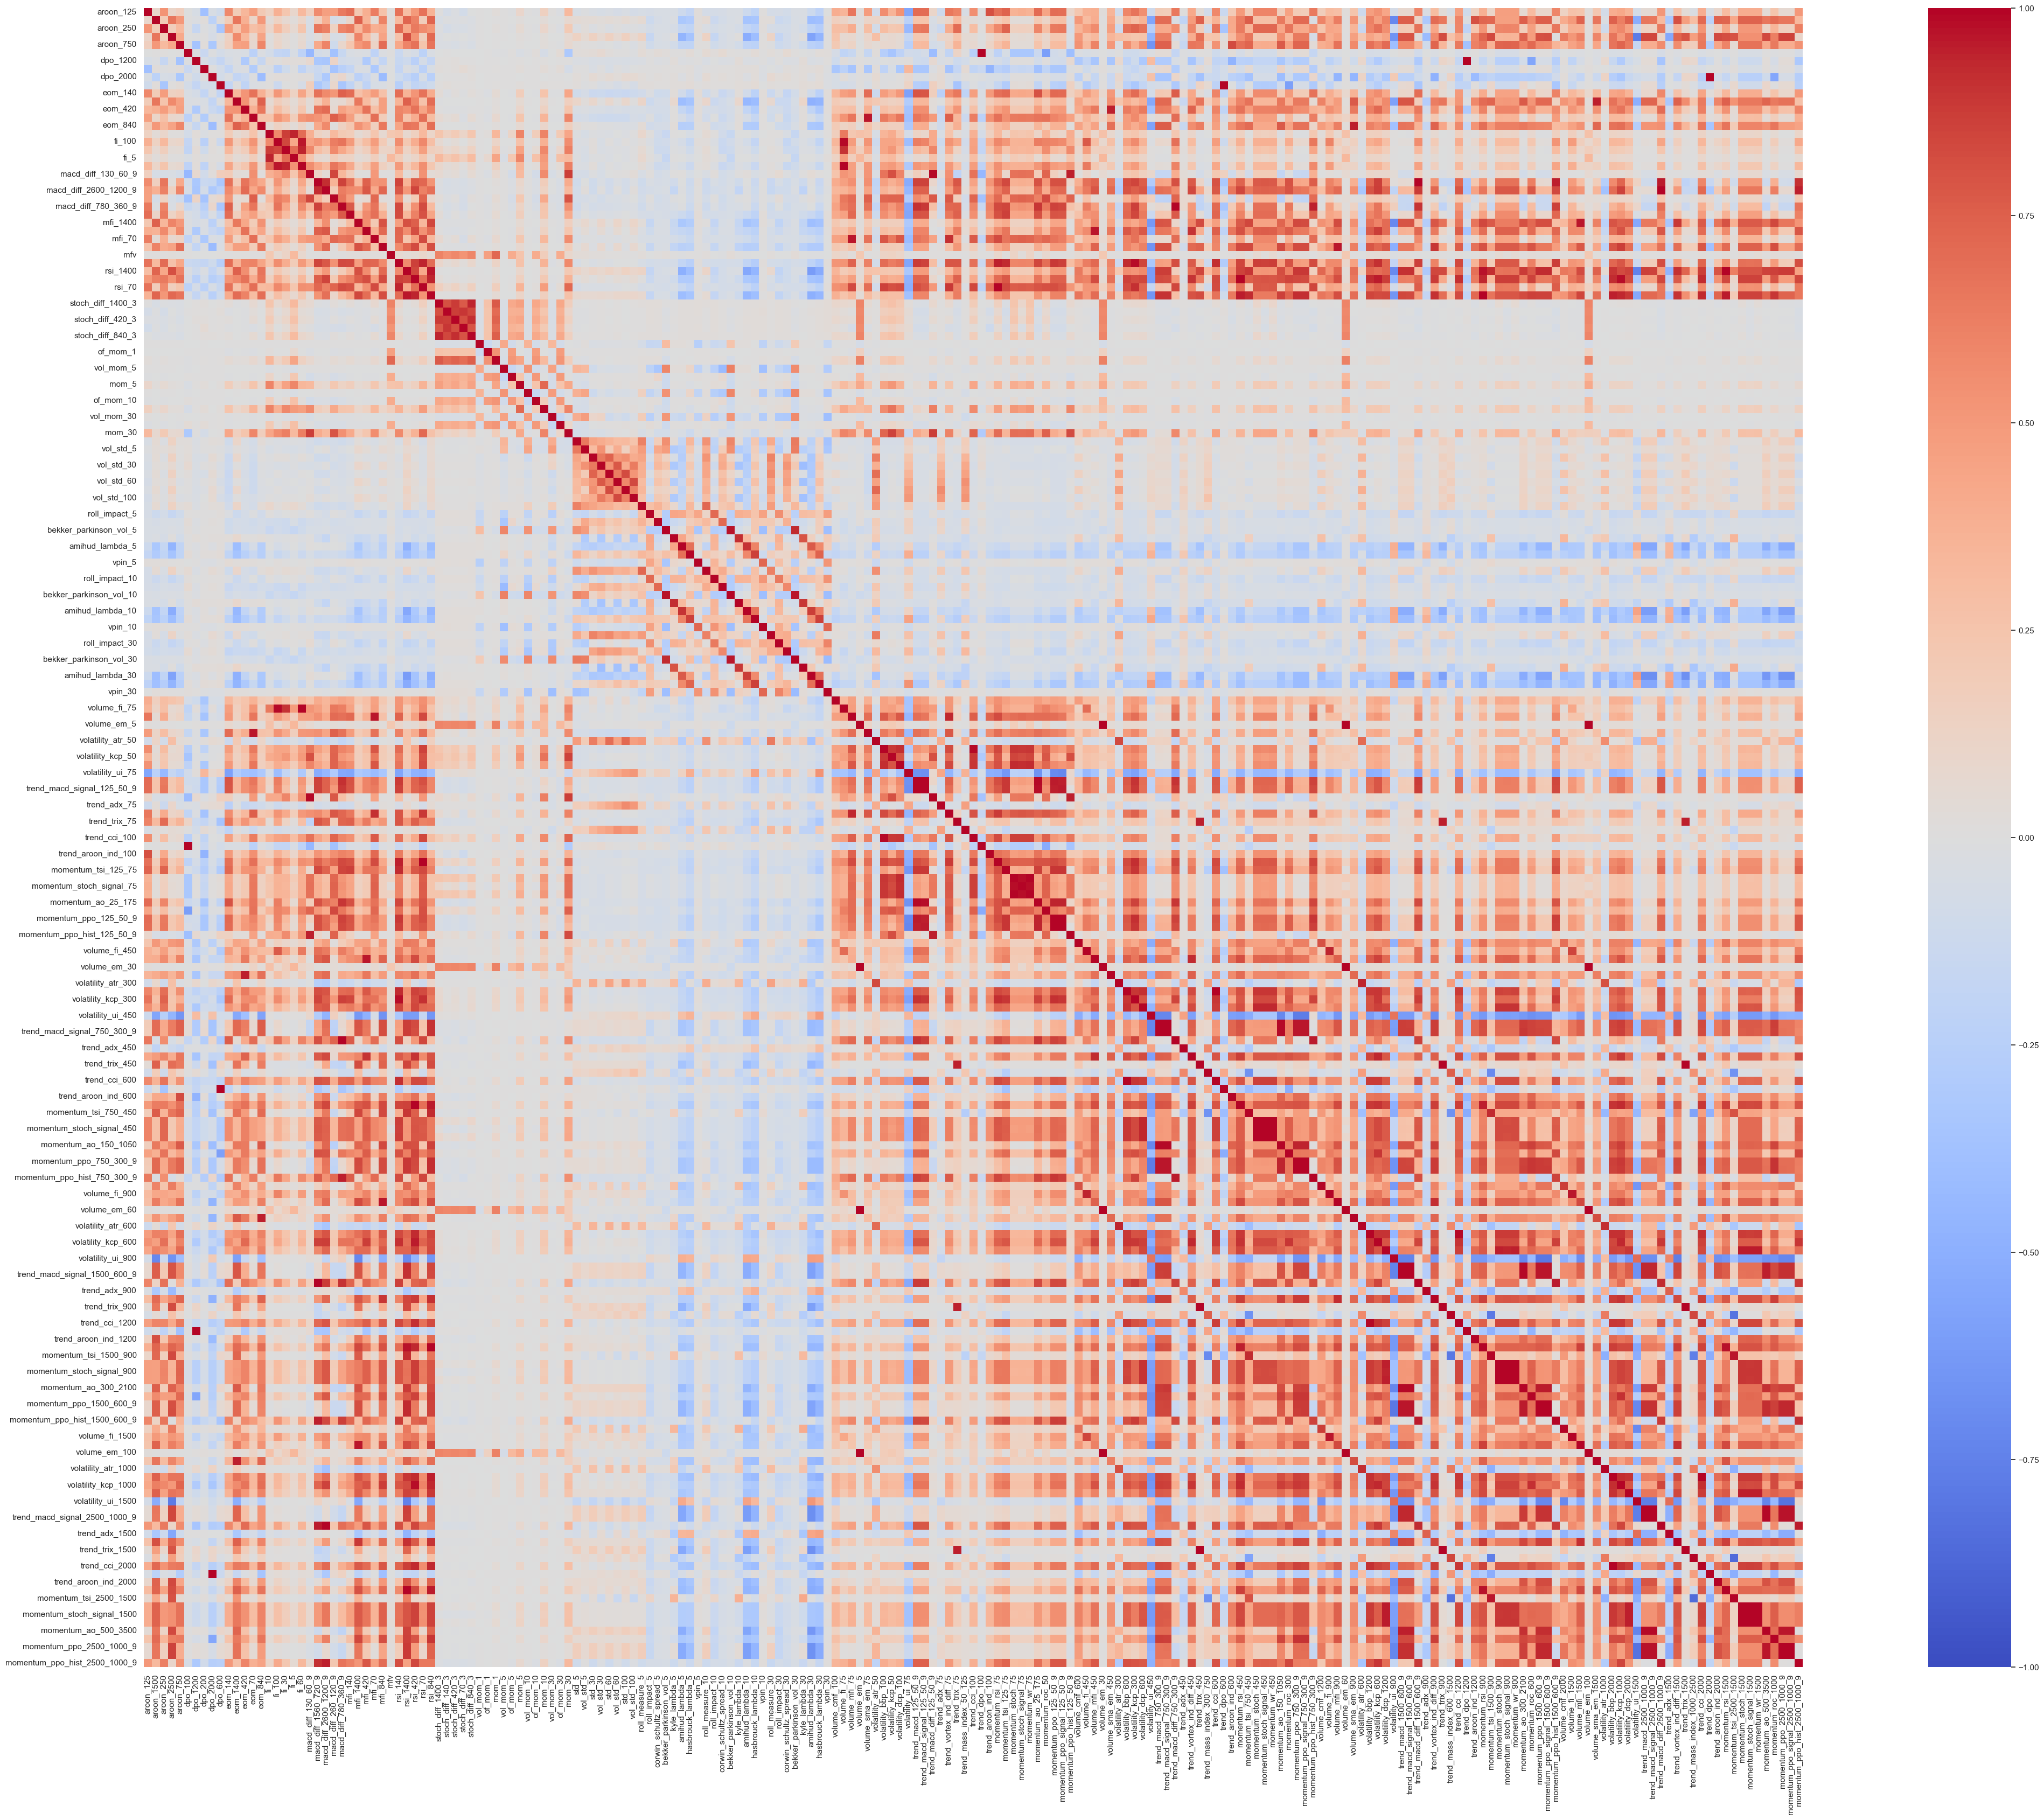

In [119]:
plt.figure(figsize=(60,40))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1, square=True)
plt.savefig('image/feature_corr.png')
plt.show()

You can use all features, but I remove some features that are highly linearly correlated.

In [120]:
# Highly correlated market features

h = 0.75
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))[::2,:]
hc_list


array([['amihud_lambda_10', 'amihud_lambda_30'],
       ['amihud_lambda_10', 'amihud_lambda_5'],
       ['amihud_lambda_30', 'amihud_lambda_5'],
       ...,
       ['volume_fi_450', 'volume_fi_900'],
       ['volume_mfi_1500', 'volume_mfi_900'],
       ['volume_sma_em_1500', 'volume_sma_em_900']], dtype='<U31')

In [121]:
drop_features = np.unique(hc_list[:,1])
drop_features

array(['amihud_lambda_30', 'amihud_lambda_5', 'bekker_parkinson_vol_30',
       'bekker_parkinson_vol_5', 'fi_30', 'fi_5', 'fi_60',
       'hasbrouck_lambda_30', 'hasbrouck_lambda_5', 'kyle_lambda_30',
       'kyle_lambda_5', 'macd_diff_2600_1200_9', 'macd_diff_260_120_9',
       'macd_diff_780_360_9', 'mfi_140', 'mfi_420', 'mfi_840', 'mom_30',
       'momentum_ao_150_1050', 'momentum_ao_25_175',
       'momentum_ao_300_2100', 'momentum_ao_500_3500',
       'momentum_ppo_125_50_9', 'momentum_ppo_1500_600_9',
       'momentum_ppo_2500_1000_9', 'momentum_ppo_750_300_9',
       'momentum_ppo_hist_125_50_9', 'momentum_ppo_hist_1500_600_9',
       'momentum_ppo_hist_2500_1000_9', 'momentum_ppo_hist_750_300_9',
       'momentum_ppo_signal_125_50_9', 'momentum_ppo_signal_1500_600_9',
       'momentum_ppo_signal_2500_1000_9', 'momentum_ppo_signal_750_300_9',
       'momentum_roc_1000', 'momentum_roc_300', 'momentum_roc_50',
       'momentum_roc_600', 'momentum_rsi_1500', 'momentum_rsi_450',
  

In [122]:
mkt1 = mkt.drop(columns=drop_features)
corr2 = mkt1.corr()

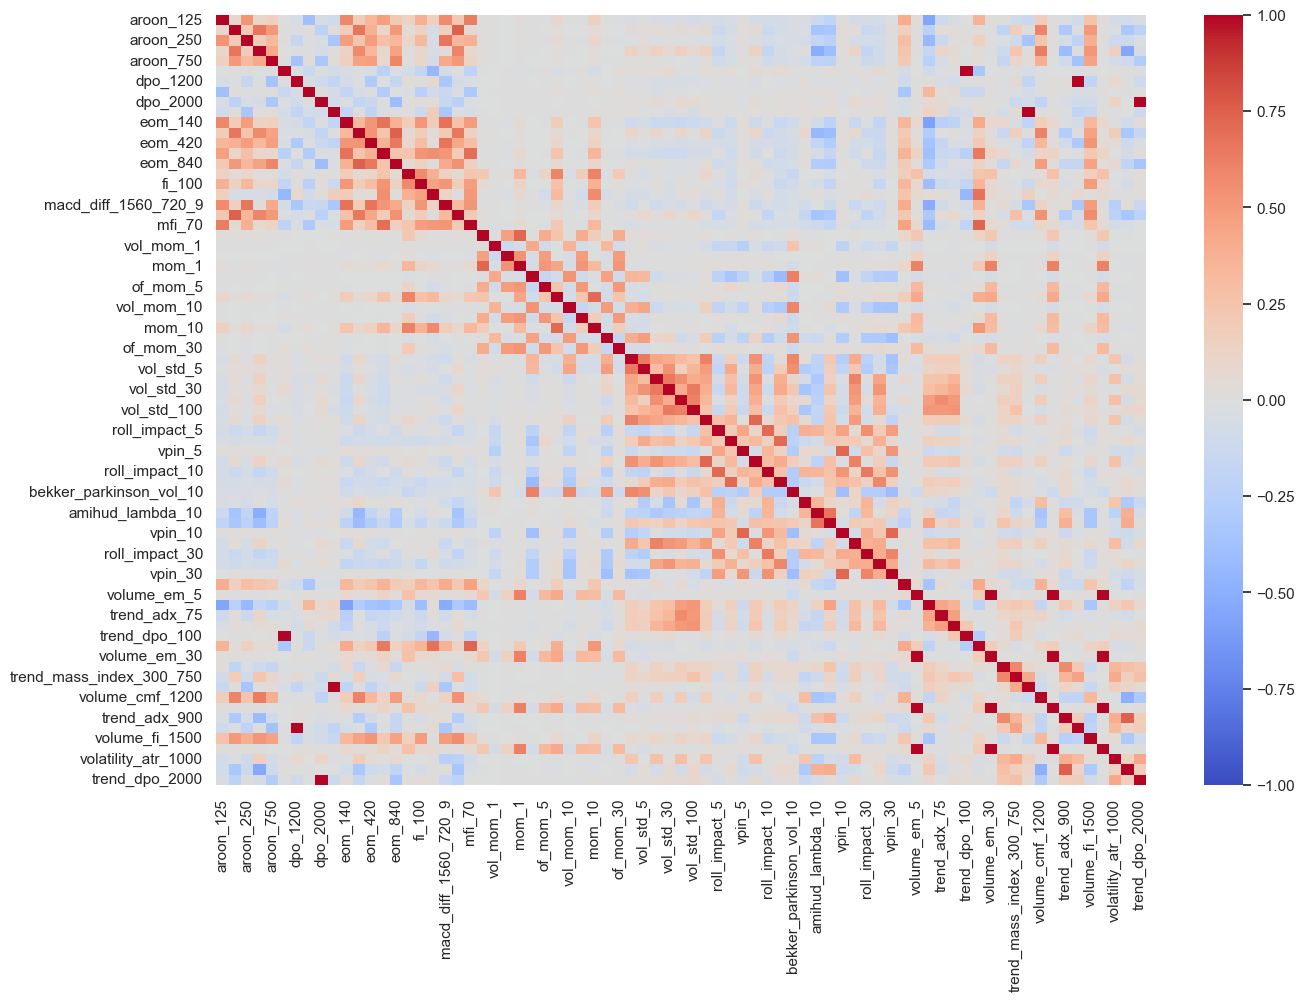

In [123]:
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

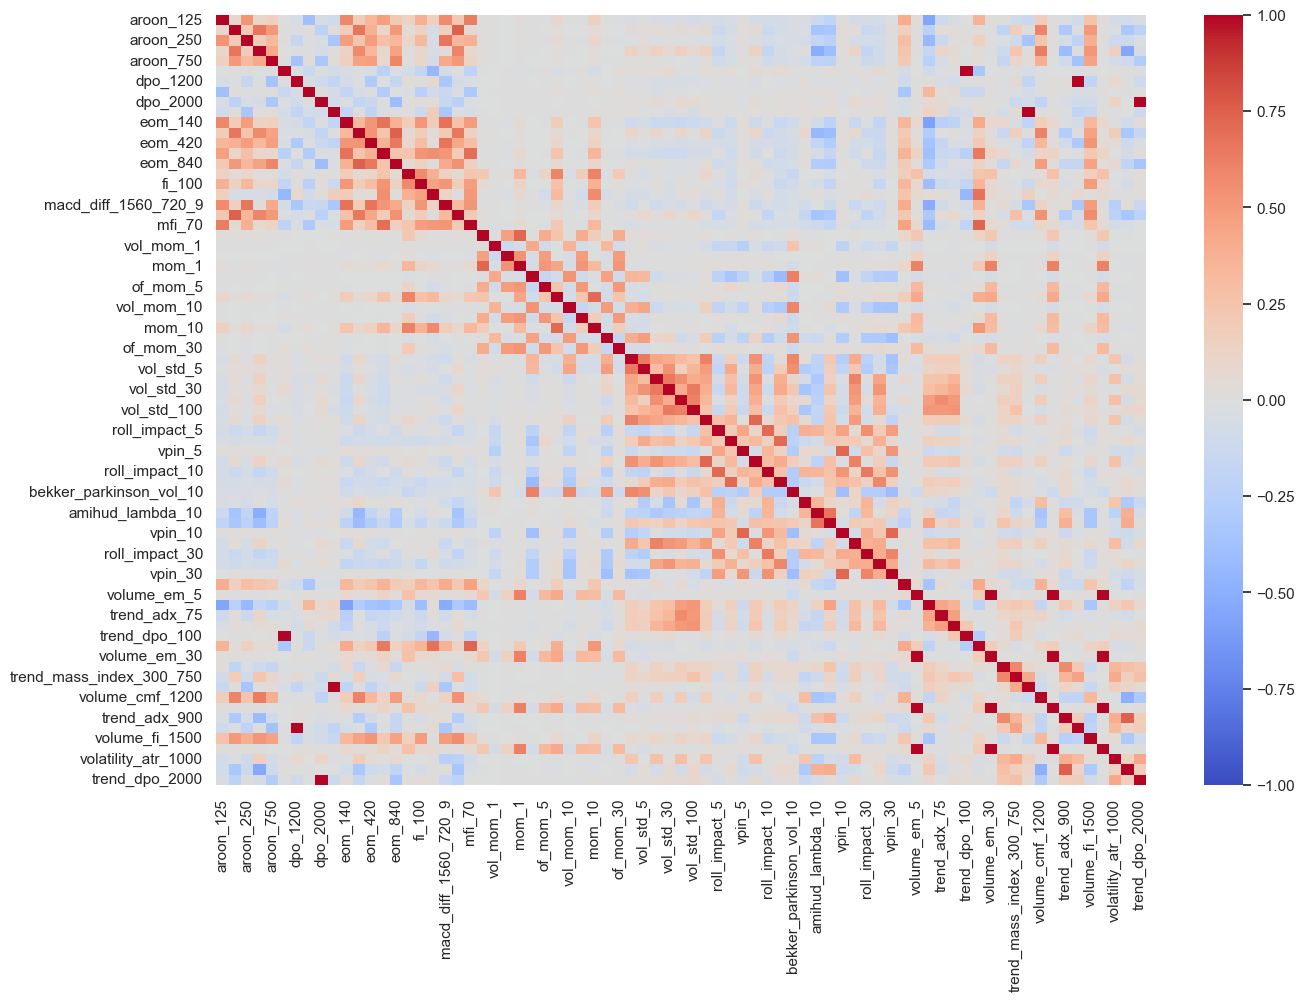

In [124]:
corr2 = mkt1.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

### Market Microstructures

We don't have tick data to build microstructure features.

It would be very helpful with that data.

In [125]:
# ### Market Microstructures
# # 使用新添加的便捷函数生成微观结构特征
# ms_features = ms.get_microstructure_features(df, window=20)

# # 将其加入到主特征矩阵 mkt1 中
# mkt1 = mkt1.join(ms_features)

# # 检查一下生成的结果
# ms_features.tail()

### Fundamentals

It is not easy to get fundamental data for 5 minutes Ethereum price.

### Sentiments

We can get features from Natural Language Process.

Working on this.

In [126]:
raw_X = mkt1.shift(1).copy()

In [127]:
# for i in raw_X.columns:
#     plt.figure(figsize=(8,1))
#     plt.plot(raw_X[i])
#     plt.legend([i])

## Feature Engineering

### Feature Scaling

Do it train, test data seperately.
I fit the scaler only on the training dataset and then transform the test set.

*Due to computational cost (in autoencoders), I did scaling and dimension-reduction of index of meta-labels'.*


MINMAX

In [128]:
y = pnllabel.copy().rename('y').to_frame()
train_index = y.loc[:end_date_train]
test_index = y.loc[start_date_test:]

In [129]:
train_index.index
# raw_X

DatetimeIndex(['2025-01-03 02:00:00', '2025-01-03 02:15:00',
               '2025-01-03 03:00:00', '2025-01-03 03:15:00',
               '2025-01-03 03:30:00', '2025-01-03 03:45:00',
               '2025-01-03 05:30:00', '2025-01-03 05:45:00',
               '2025-01-03 06:00:00', '2025-01-03 06:30:00',
               ...
               '2025-06-01 20:15:00', '2025-06-01 20:30:00',
               '2025-06-01 21:00:00', '2025-06-01 21:15:00',
               '2025-06-01 21:30:00', '2025-06-01 21:45:00',
               '2025-06-01 22:00:00', '2025-06-01 22:30:00',
               '2025-06-01 23:00:00', '2025-06-01 23:45:00'],
              dtype='datetime64[ns]', name='open_time', length=7244, freq=None)

In [130]:
raw_X_train = raw_X.loc[train_index.index].dropna()
raw_X_test = raw_X.loc[test_index.index].dropna()

In [131]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X_train)

scaled_X_train = pd.DataFrame(scaler.transform(raw_X_train),index=raw_X_train.index,columns=raw_X.columns)
scaled_X_test = pd.DataFrame(scaler.transform(raw_X_test),index=raw_X_test.index,columns=raw_X.columns)

### Dimension Reduction
- PCA - linear
- Deep Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

https://github.com/jo-cho/ML_Finance_Codes/blob/master/Chapter8-Advanced-NNs/ML_in_Finance-RNNs-Bitcoin.ipynb

In [132]:
# PCA
n=5

pca = PCA(n)
pca.fit(scaled_X_train)

pca_X_train = pd.DataFrame(pca.transform(scaled_X_train),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_train.index)

pca_X_test = pd.DataFrame(pca.transform(scaled_X_test),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_test.index)

In [133]:
components_ = pca.components_

In [134]:
loadings = pd.DataFrame(components_, index = pca_X_train.columns, columns=mkt1.columns).T

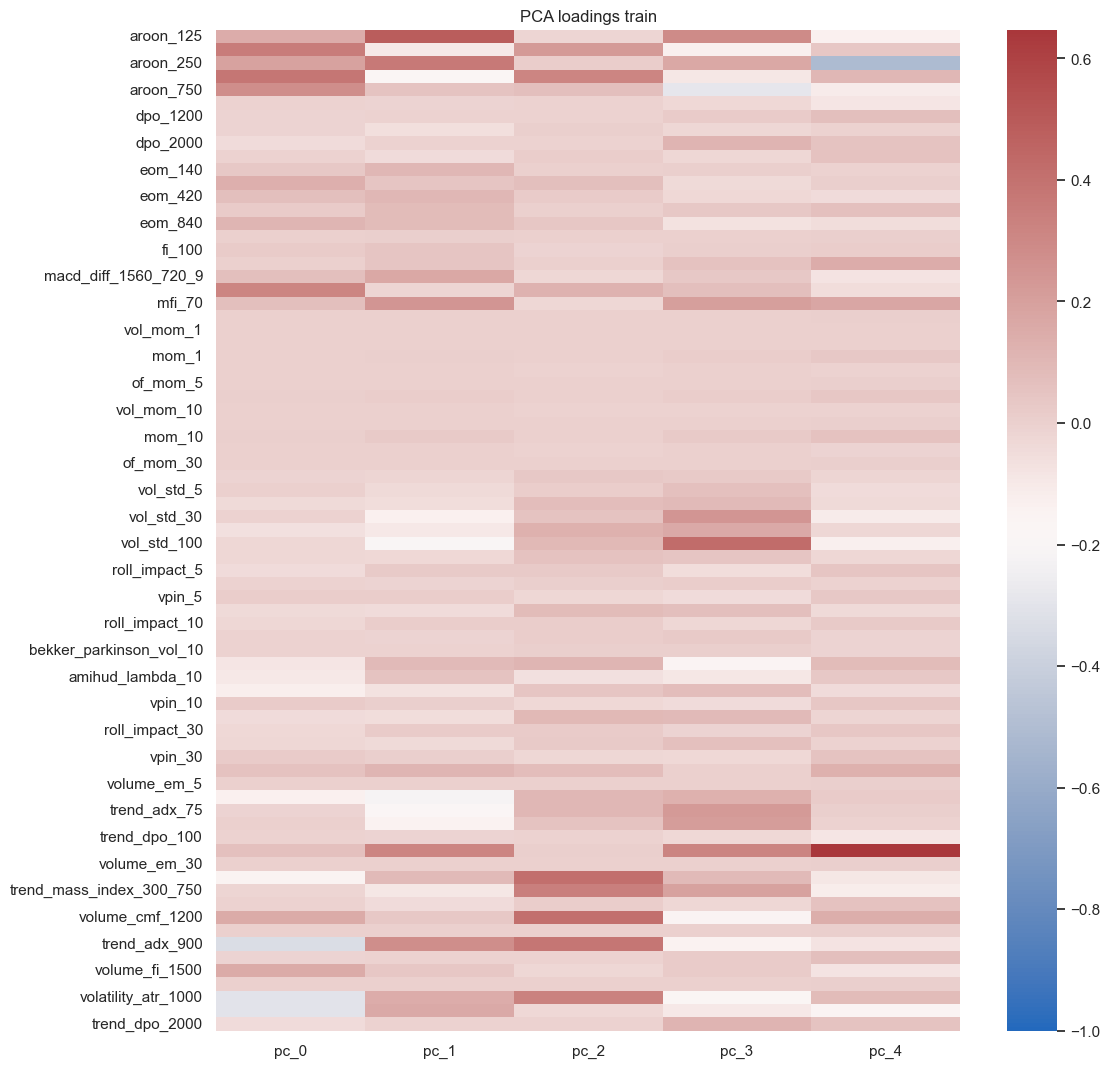

In [135]:
f = plt.figure(figsize=(12, 13))
sns.heatmap(loadings,cmap='vlag',vmin=-1)
plt.title('PCA loadings train')
plt.savefig('image/pcaloadings.jpg')
plt.show();

**Deep Autoencoders**

Non-Linear stacked autoencoders

https://towardsdatascience.com/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743

In [136]:
x = scaled_X_train.copy()

epochs=100
dimension=5

In [137]:
keras.backend.clear_session()

In [138]:
nl_encoder = keras.models.Sequential([
    keras.layers.Dense(20, input_shape=[x.shape[1]], activation='relu'),
    keras.layers.Dense(15, activation='selu'),
    keras.layers.Dense(dimension, activation='selu'),
])

nl_decoder = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=[dimension], activation='selu'),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(x.shape[1], activation='relu'),
])

nl_autoencoder = keras.models.Sequential([nl_encoder, nl_decoder])
nl_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.1))
nl_autoencoder.summary()


history = nl_autoencoder.fit(x,x, epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(monitor='loss',patience=10)],
                             verbose=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 5)              │         1,915 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 75)             │         1,985 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,900 (15.23 KB)

 Trainable params: 3,900 (15.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4699
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5125
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5167
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5138
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5086
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5018
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4973
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4966
Epoch 9/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4971
Epoch 10/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4989
Epoch 11/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5008


In [139]:
encoded_X_train = nl_encoder.predict(scaled_X_train)
encoded_X_train = pd.DataFrame(encoded_X_train, index=scaled_X_train.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

encoded_X_test = nl_encoder.predict(scaled_X_test)
encoded_X_test = pd.DataFrame(encoded_X_test, index=scaled_X_test.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [140]:
encoded_X_train

,encoded_0,encoded_1,encoded_2,encoded_3,encoded_4
open_time,,,,,
2025-01-27 01:15:00,1.623875,-0.867112,-1.650879,0.663445,-0.927411
2025-01-27 01:30:00,1.761829,-0.816437,-1.636936,0.635901,-0.963011
2025-01-27 02:30:00,1.817677,-0.820179,-1.622984,0.611126,-0.986167
2025-01-27 03:00:00,1.730637,-0.816838,-1.617791,0.620566,-1.009416
2025-01-27 03:15:00,1.779714,-0.777336,-1.627487,0.653422,-1.049025
...,...,...,...,...,...
2025-06-01 21:45:00,2.129106,-0.559131,-1.589185,0.336139,-0.993650
2025-06-01 22:00:00,2.076501,-0.542686,-1.577499,0.337093,-1.003311
2025-06-01 22:30:00,2.153031,-0.607064,-1.599994,0.314424,-0.962739


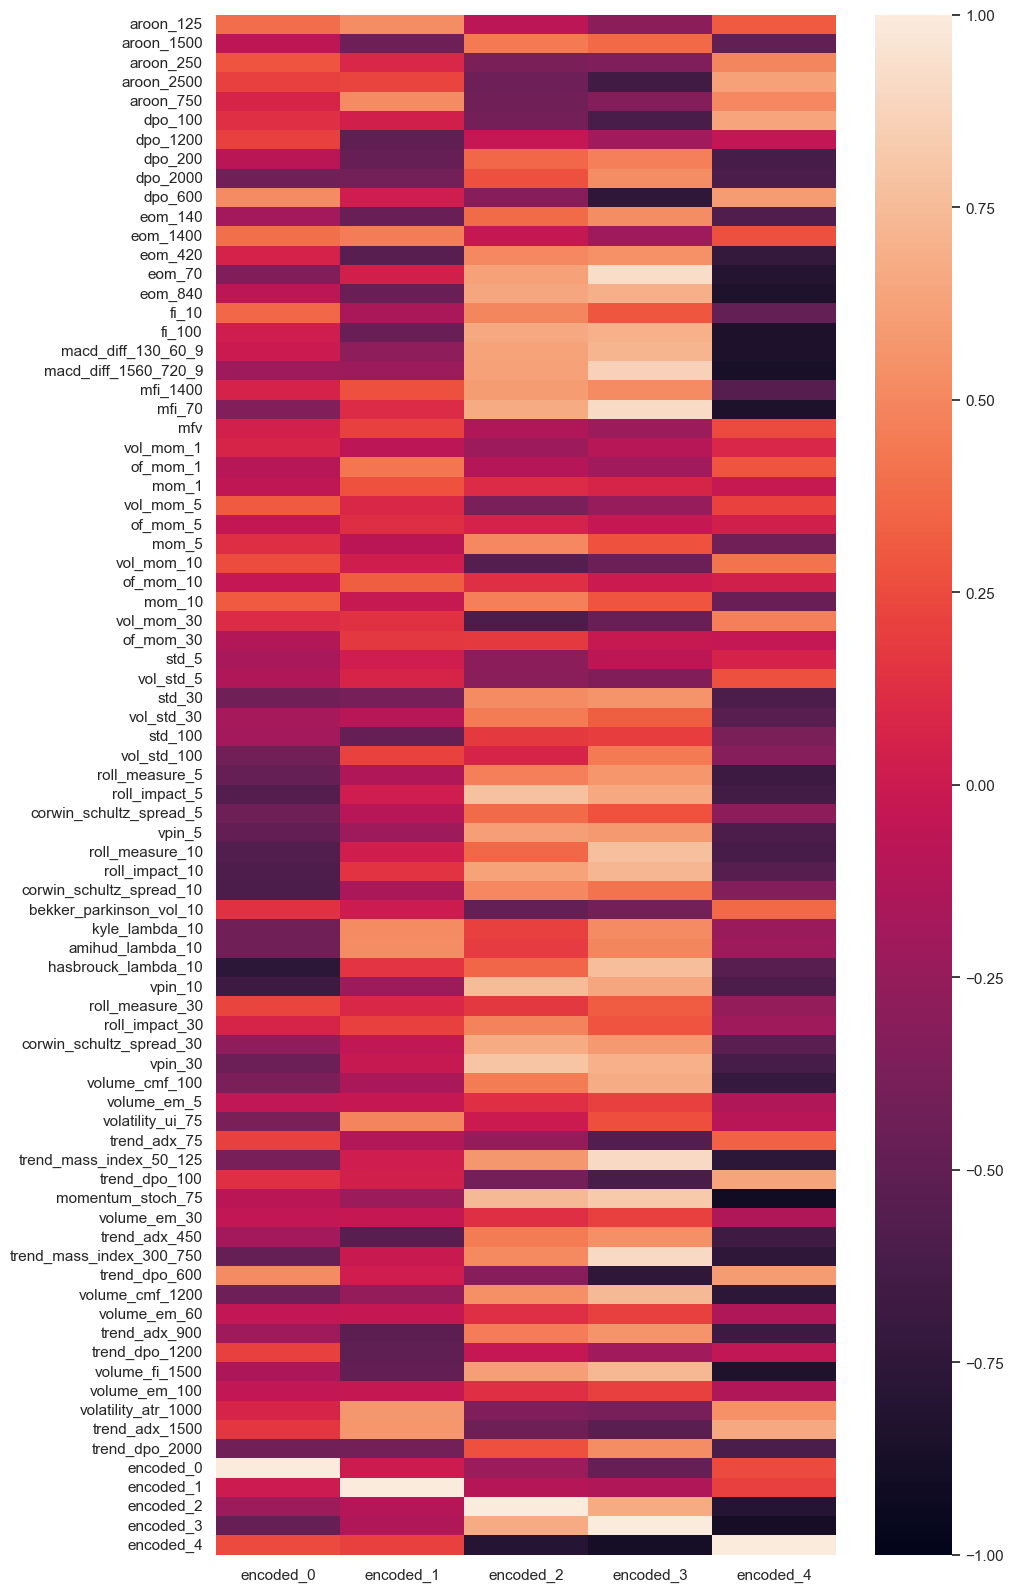

In [141]:
corr_encoded = scaled_X_test.join(encoded_X_train).corr().iloc[-5:].T

plt.figure(figsize=(10,20))
sns.heatmap(corr_encoded,vmin=-1,vmax=1)
plt.show()

COMPARE PCA and Non-linear autoencoder

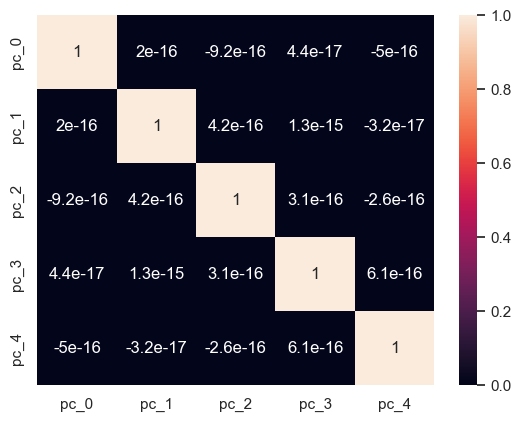

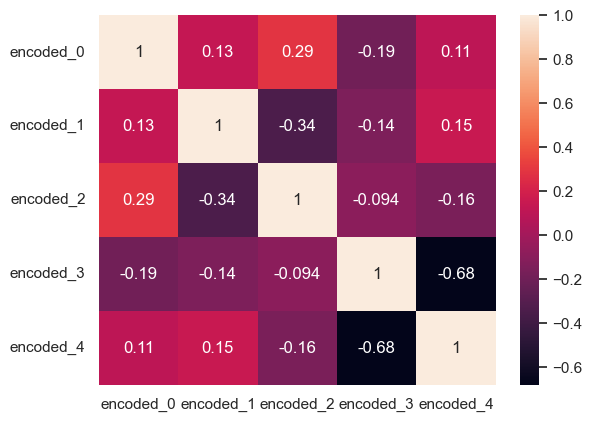

In [142]:
# correlation (linearly)
sns.heatmap(pca_X_train.corr(),annot=True)
plt.show()

sns.heatmap(encoded_X_train.corr(),annot=True)
plt.show()

# Machine Learning Model

## Hyper parameter tuning

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, it helps.

or F1 socre in general(*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. 
- Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

In [143]:
train_X = pca_X_train.copy() 
# or
#train_X= encoded_X_train.copy()

test_X = pca_X_test.copy()
# or
#test_X= encoded_X_test.copy()<Increasing p (probability of winning)>

FYI using encoded_X, the best precision score of auto ML models is around 0.66

In [144]:
train_data = train_X.join(train_y).dropna()
test_data = test_X.join(test_y).dropna()

## AutoML with autogluon and select the best model

In [145]:
from autogluon.tabular import TabularPredictor

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

or F1 socre (*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

This *autogluon* supports a number of machine learning models, and automatically chooses optimal hyperparameters given which score to be optimized.

And also it does CV, but not Purged K-Fold which was suggested by De Prado

So we choose precision score to be maximized. (but there are some problems with *n*(annual betting opportuinites).)

In [146]:
predictor = TabularPredictor(label='y', eval_metric='precision').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20260103_135843"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:17:35 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T8112
CPU Count:          8
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
Memory Avail:       3.60 GB / 16.00 GB (22.5%)
Disk Space Avail:   160.09 GB / 460.43 GB (34.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme'  : New in v1.5: The state-of-the-art for tabular data. Massively better than 'best' on datasets <100000 samples by using new Tabula

limitation
- shuffle 
- not good cv for finance data

In [147]:
result = predictor.leaderboard(test_data, silent=True)
result

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.540006,0.958333,precision,0.096214,0.059792,0.478342,0.096214,0.059792,0.478342,1,True,7
1,NeuralNetTorch,0.538342,0.961131,precision,0.013341,0.003534,27.983237,0.013341,0.003534,27.983237,1,True,10
2,ExtraTreesGini,0.538040,0.951724,precision,0.093891,0.055377,0.489149,0.093891,0.055377,0.489149,1,True,6
3,LightGBMLarge,0.537484,0.957895,precision,0.036331,0.005912,7.636447,0.036331,0.005912,7.636447,1,True,11
4,RandomForestEntr,0.528197,0.958042,precision,0.073260,0.059708,0.793876,0.073260,0.059708,0.793876,1,True,4
5,CatBoost,0.527137,0.968085,precision,0.004623,0.000663,0.933602,0.004623,0.000663,0.933602,1,True,5
6,XGBoost,0.525222,0.961672,precision,0.012171,0.002180,2.018574,0.012171,0.002180,2.018574,1,True,9
7,WeightedEnsemble_L2,0.520942,0.979094,precision,0.206547,0.082594,39.921209,0.003795,0.002669,0.323265,2,True,12
8,LightGBM,0.520444,0.958333,precision,0.037730,0.004313,3.943811,0.037730,0.004313,3.943811,1,True,2
9,RandomForestGini,0.512795,0.954545,precision,0.073448,0.059931,0.702915,0.073448,0.059931,0.702915,1,True,3


In [148]:
best_model = result.model[0]

In [149]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print(best_model, "'s predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

ExtraTreesEntr 's predictions:  
 open_time
2025-06-01 00:30:00    1.0
2025-06-01 00:45:00    1.0
2025-06-01 01:00:00    1.0
2025-06-01 02:15:00    1.0
2025-06-01 02:30:00    1.0
                      ... 
2025-09-27 22:00:00   -1.0
2025-09-27 22:15:00   -1.0
2025-09-27 22:45:00   -1.0
2025-09-27 23:00:00   -1.0
2025-09-27 23:45:00   -1.0
Name: y, Length: 5840, dtype: float64


## Feature Importance

In autogluon,

- A feature's importance score represents the performance drop that results when the model makes predictions on a perturbed copy of the data where this feature's values have been randomly shuffled across rows.
- A feature score of 0.01 would indicate that the predictive performance dropped by 0.01 when the feature was randomly shuffled.
- The higher the score a feature has, the more important it is to the model's performance.
- If a feature has a negative score, this means that the feature is likely harmful to the final model, and a model trained with the feature removed would be expected to achieve a better predictive performance.

In [150]:
for i in result.model:
    print(i, "'s Feature Importance")
    fi = predictor.feature_importance(test_data, model=i, silent=True)
    print(fi)
    print('\n')

ExtraTreesEntr 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_3    0.020945  0.003686  0.000111  5  0.028536  0.013355
pc_4    0.018958  0.003051  0.000078  5  0.025239  0.012677
pc_2    0.009627  0.006410  0.014179  5  0.022826 -0.003572
pc_0    0.000748  0.002438  0.265085  5  0.005769 -0.004272
pc_1   -0.014472  0.004927  0.998610  5 -0.004327 -0.024616


NeuralNetTorch 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_3    0.014007  0.004305  0.000948  5  0.022872  0.005143
pc_4    0.013473  0.004644  0.001455  5  0.023034  0.003912
pc_2    0.002916  0.008474  0.242269  5  0.020363 -0.014531
pc_0   -0.003300  0.003960  0.932056  5  0.004854 -0.011454
pc_1   -0.016378  0.004047  0.999587  5 -0.008044 -0.024711


ExtraTreesGini 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_3    0.022571  0.003202  0.000047  5  0.029165  0.015977
pc_4    0.020857  0.002101  0.000012  5  0.02

## Results with PnL

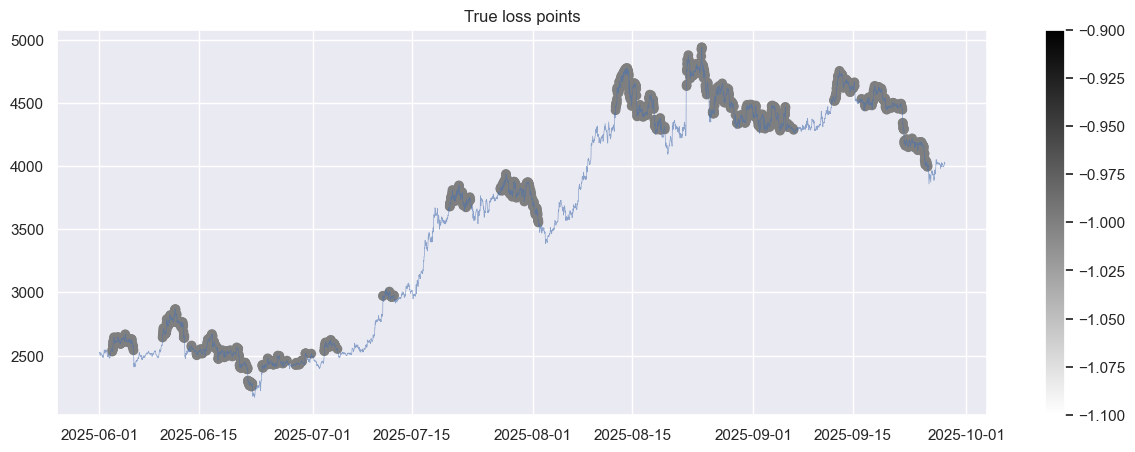

In [151]:
sc = y_true2.loc[y_true2==-1]
title = 'True loss points'
figure_scatter(sc,close.loc[y_true2.index],title,cmap='gray_r')

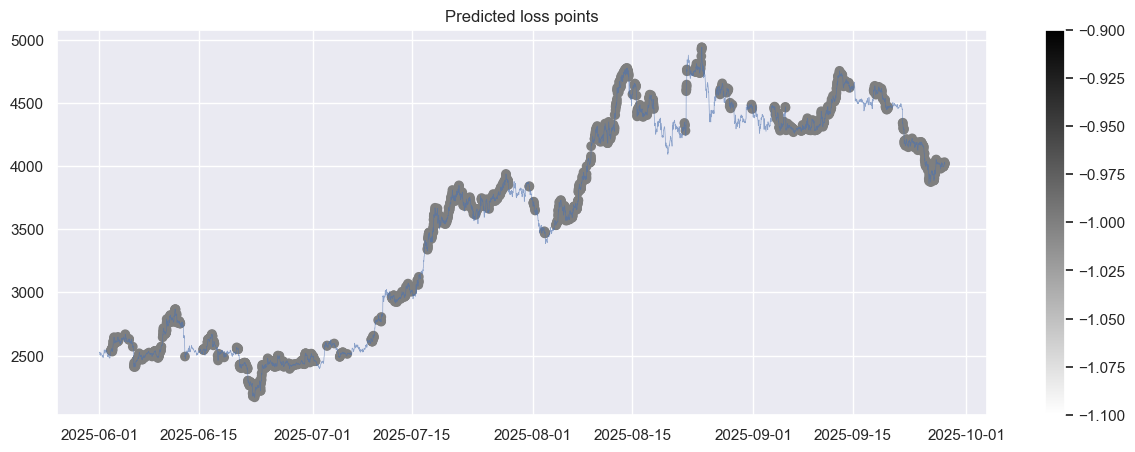

In [152]:
sc = y_pred2.loc[y_pred2==-1]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [153]:
# After drop predicted loss
predlabel = y_true2.drop(index=y_pred2.loc[y_pred2==-1].index)
predlabel.value_counts()

y
 1.0    1667
-1.0    1420
Name: count, dtype: int64

In [154]:
print('이익확률 pi: ',predlabel.value_counts().values[0] / predlabel.value_counts().values.sum())

이익확률 pi:  0.540006478781989


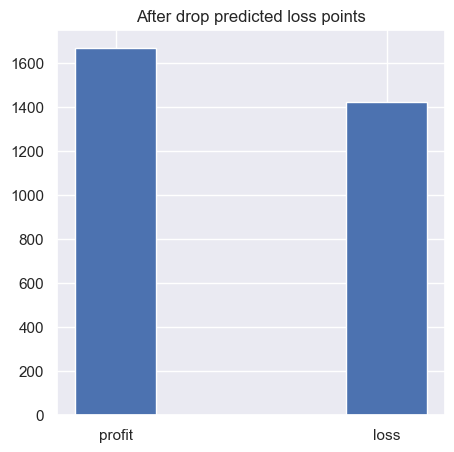

In [155]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel.value_counts(), width=0.3)
plt.title('After drop predicted loss points')
plt.savefig('image/pnl_2nd.png')
plt.show()

the pitfalls of maximizing precision score:

there can be huge diminish in bet opportunities.

Using Predicted Probabilities adjust it.
from 0.5 to maybe 0.8

In [156]:
y_pred_prob2 = predictor.predict_proba(test_data)
y_pred_prob2

,-1.0,1.0
open_time,,
2025-06-01 00:30:00,0.050156,0.949844
2025-06-01 00:45:00,0.046749,0.953251
2025-06-01 01:00:00,0.062706,0.937294
2025-06-01 02:15:00,0.080827,0.919173
2025-06-01 02:30:00,0.082623,0.917377
...,...,...
2025-09-27 22:00:00,0.848750,0.151250
2025-09-27 22:15:00,0.887937,0.112063
2025-09-27 22:45:00,0.870197,0.129803


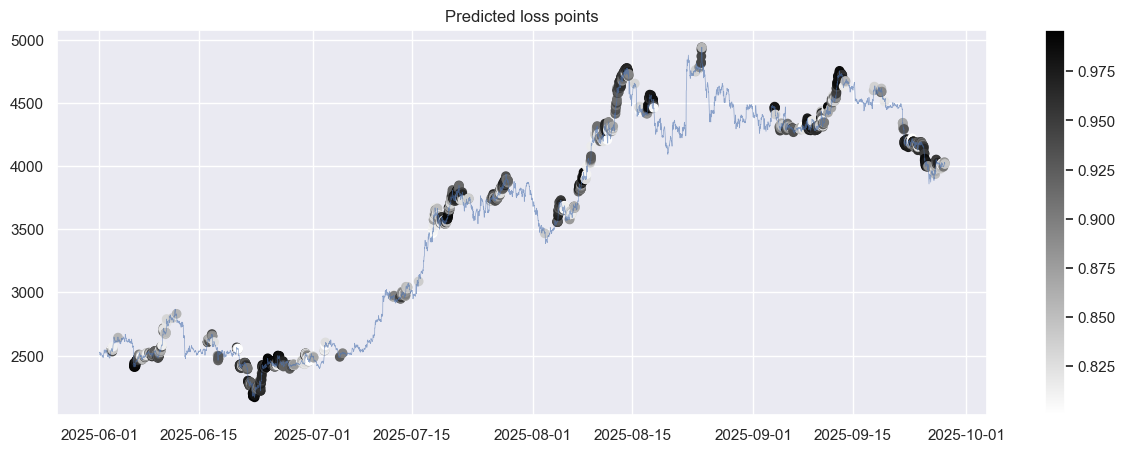

In [157]:
pred_loss = y_pred_prob2[-1]
sc = pred_loss.loc[pred_loss>0.8]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [158]:
# After drop predicted loss
predlabel2 = y_true2.drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.8].index)
predlabel2.value_counts()

y
 1.0    2104
-1.0    1862
Name: count, dtype: int64

In [159]:
print('이익확률 pi: ',predlabel2.value_counts().values[0] / predlabel2.value_counts().values.sum())

이익확률 pi:  0.5305093292990418


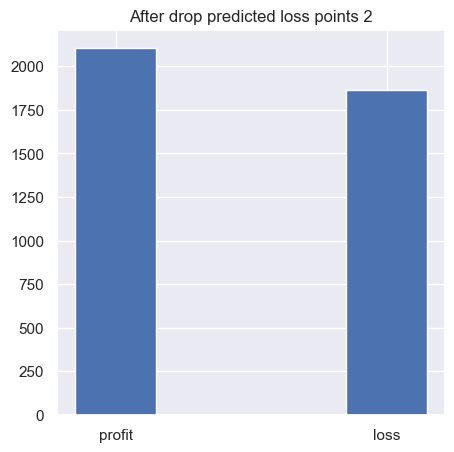

In [160]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel2.value_counts(), width=0.3)
plt.title('After drop predicted loss points 2')
plt.savefig('image/pnl_2nd2.png')
plt.show()

Solution (in process):

When choosing the optimal model, consider not only precision score but also the number of betting opportunities.

More specifically maximizing annualized Sharpe ratio.


see returns

In [161]:
finret = ret.loc[y_true2.index].drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>0.5].index)
finret

open_time
2025-06-01 00:30:00    0.026067
2025-06-01 00:45:00    0.028423
2025-06-01 01:00:00    0.032287
2025-06-01 02:15:00    0.041882
2025-06-01 02:30:00    0.040506
                         ...   
2025-09-26 07:45:00    0.042278
2025-09-26 10:30:00    0.058504
2025-09-26 11:15:00    0.053496
2025-09-26 11:30:00    0.048988
2025-09-27 20:00:00    0.036758
Name: ret, Length: 2889, dtype: float64

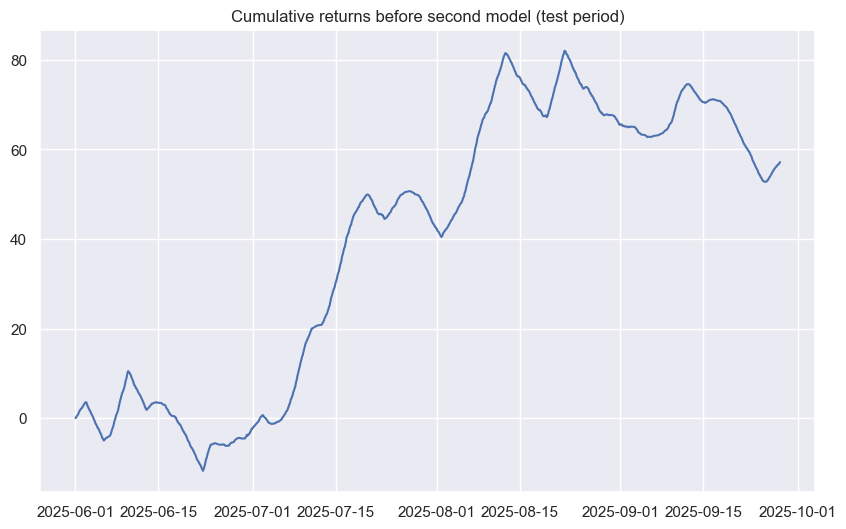

In [162]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns before second model (test period)')
plt.plot(ret.loc[y_true2.index].cumsum())
plt.savefig('image/cumsum_ret_1st_test.png')
plt.show()

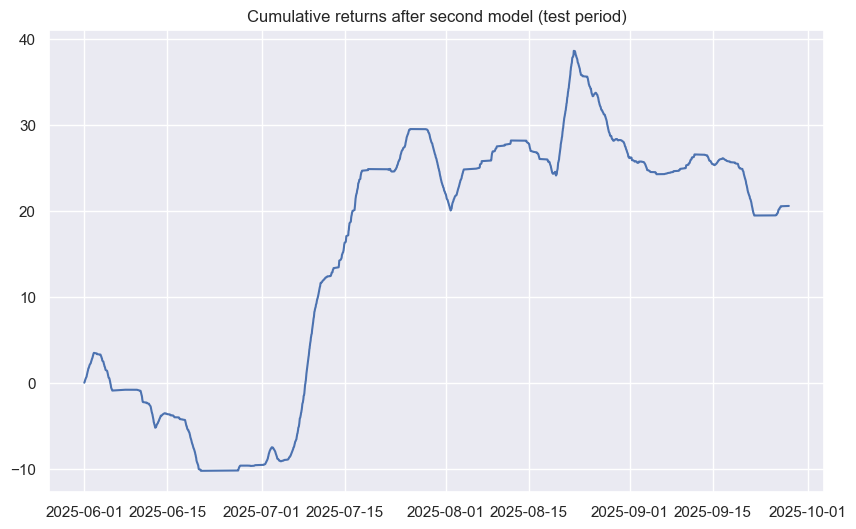

In [163]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns after second model (test period)')
plt.plot(finret.cumsum())
plt.savefig('image/cumsum_ret_2nd_test.png')
plt.show()

### Trading

#### bet sizing

- Kelly rules (when betting data is normally dist.)
- Use predicted probabilities as bet confidence (suggested by DePrado)

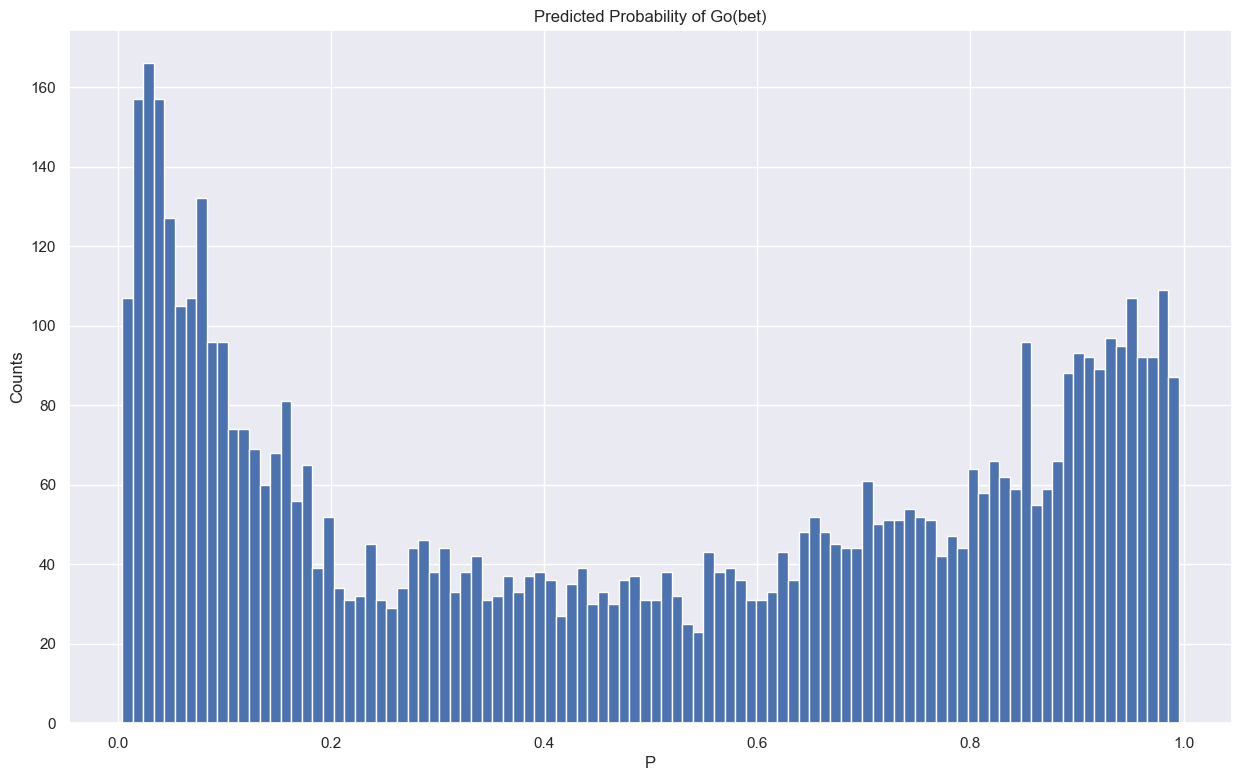

In [164]:
p = y_pred_prob2[1]
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Predicted Probability of Go(bet)')
plt.savefig('image/predprob.jpg')
plt.show()

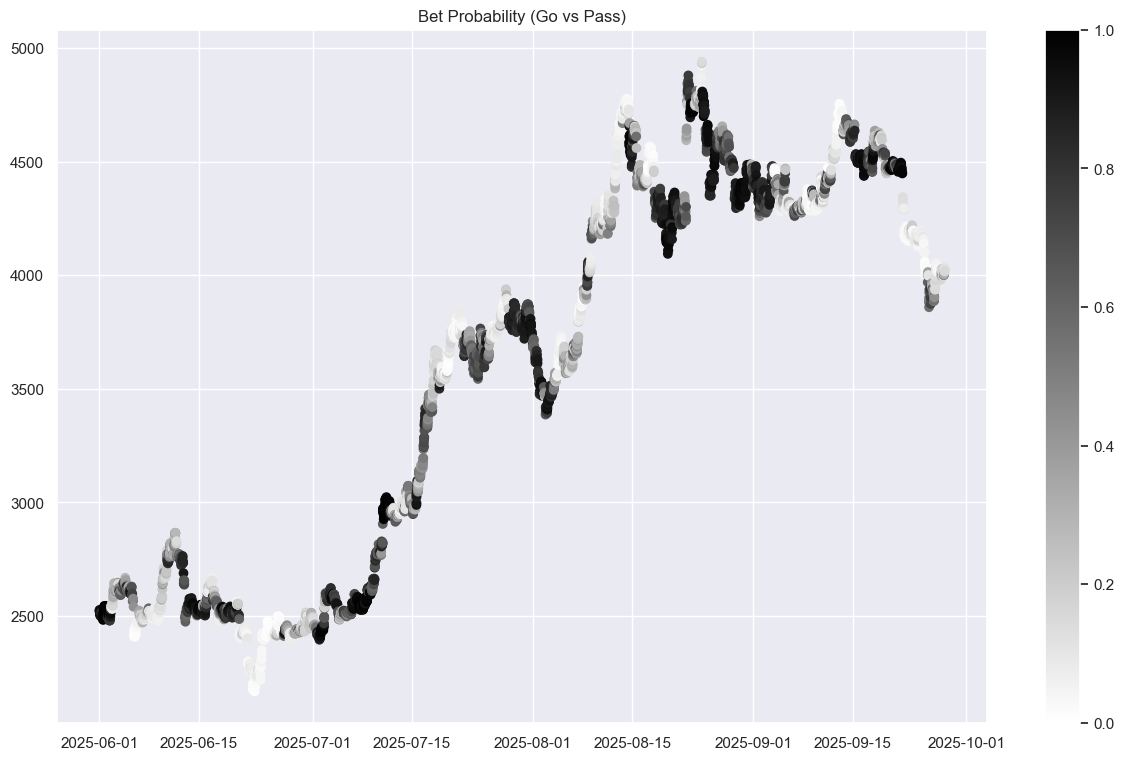

In [165]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= p, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.savefig('image/bet_prob.png')
plt.show()

## Bet Sizing

- not perfect yet

In [166]:
def get_signal(prob, num_classes):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [167]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [168]:
prob = p.copy()

m = get_signal(prob, 2)
# m
m = discretize(m, 0.25)

In [169]:
m

open_time
2025-06-01 00:30:00    1.00
2025-06-01 00:45:00    1.00
2025-06-01 01:00:00    1.00
2025-06-01 02:15:00    1.00
2025-06-01 02:30:00    0.75
                       ... 
2025-09-27 22:00:00   -0.75
2025-09-27 22:15:00   -0.75
2025-09-27 22:45:00   -0.75
2025-09-27 23:00:00   -0.75
2025-09-27 23:45:00   -0.75
Name: 1.0, Length: 5840, dtype: float64

In [170]:
# we only do long position betting

m.loc[m[m<0].index] = 0
m

open_time
2025-06-01 00:30:00    1.00
2025-06-01 00:45:00    1.00
2025-06-01 01:00:00    1.00
2025-06-01 02:15:00    1.00
2025-06-01 02:30:00    0.75
                       ... 
2025-09-27 22:00:00    0.00
2025-09-27 22:15:00    0.00
2025-09-27 22:45:00    0.00
2025-09-27 23:00:00    0.00
2025-09-27 23:45:00    0.00
Name: 1.0, Length: 5840, dtype: float64

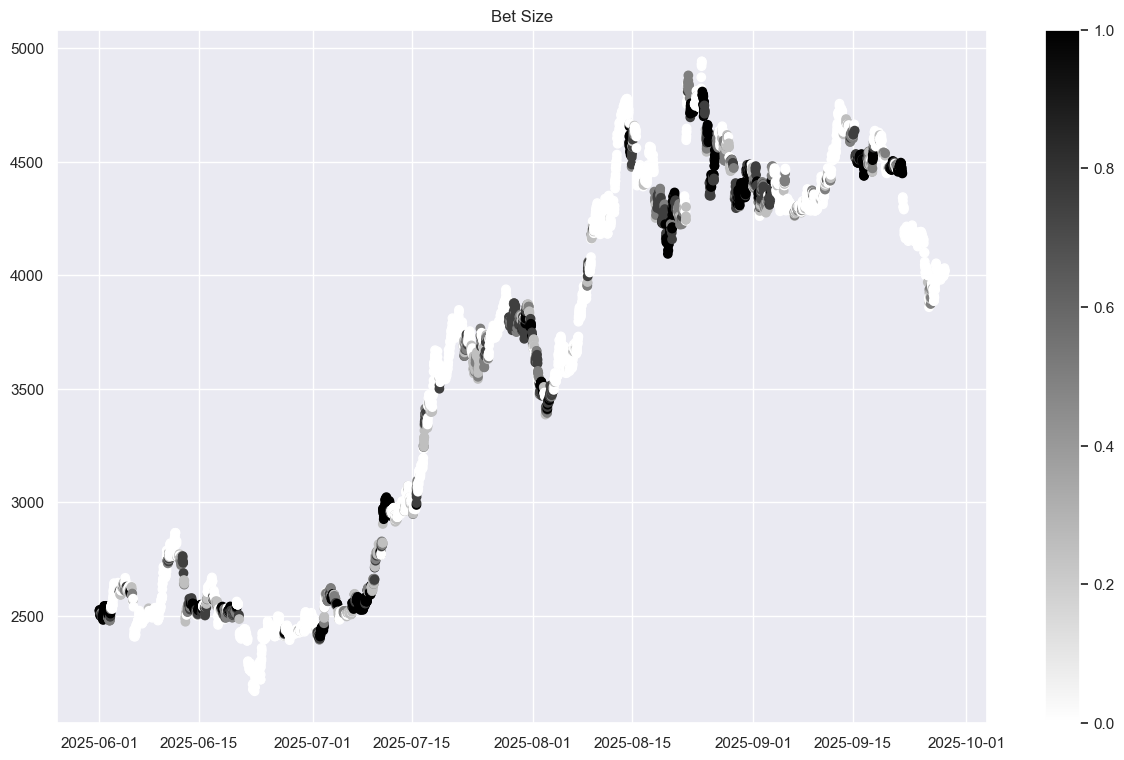

In [171]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= m, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('image/betsize.jpg')
plt.show()

## Results

### Backtest with zipline/pyfolio

We are not ready for the portfolio optimization.

Here, let us say there are only two assets (ETH and cash)

In [172]:
barrier_t = barrier.loc[y_true2.index]
barrier_t

,exit,price,side,ret
open_time,,,,
2025-06-01 00:30:00,2025-06-04 00:30:00,2521.07,1.0,0.026067
2025-06-01 00:45:00,2025-06-04 00:45:00,2525.11,1.0,0.028423
2025-06-01 01:00:00,2025-06-04 01:00:00,2527.25,1.0,0.032287
2025-06-01 02:15:00,2025-06-04 02:15:00,2506.37,1.0,0.041882
2025-06-01 02:30:00,2025-06-04 02:30:00,2509.11,1.0,0.040506
...,...,...,...,...
2025-09-27 22:00:00,2025-09-30 22:00:00,4021.22,1.0,0.033978
2025-09-27 22:15:00,2025-09-30 22:15:00,4031.28,1.0,0.029870
2025-09-27 22:45:00,2025-09-30 22:45:00,4021.00,1.0,0.028602


In [173]:
initial_money=1
bet_size = m*initial_money
bet_size

open_time
2025-06-01 00:30:00    1.00
2025-06-01 00:45:00    1.00
2025-06-01 01:00:00    1.00
2025-06-01 02:15:00    1.00
2025-06-01 02:30:00    0.75
                       ... 
2025-09-27 22:00:00    0.00
2025-09-27 22:15:00    0.00
2025-09-27 22:45:00    0.00
2025-09-27 23:00:00    0.00
2025-09-27 23:45:00    0.00
Name: 1.0, Length: 5840, dtype: float64

In [174]:
bet_size.index
# bet_size.columns()

barrier.index

DatetimeIndex(['2025-01-03 02:00:00', '2025-01-03 02:15:00',
               '2025-01-03 03:00:00', '2025-01-03 03:15:00',
               '2025-01-03 03:30:00', '2025-01-03 03:45:00',
               '2025-01-03 05:30:00', '2025-01-03 05:45:00',
               '2025-01-03 06:00:00', '2025-01-03 06:30:00',
               ...
               '2025-09-30 19:15:00', '2025-09-30 19:30:00',
               '2025-09-30 19:45:00', '2025-09-30 20:15:00',
               '2025-09-30 20:30:00', '2025-09-30 20:45:00',
               '2025-09-30 22:00:00', '2025-09-30 23:15:00',
               '2025-09-30 23:30:00', '2025-09-30 23:45:00'],
              dtype='datetime64[ns]', name='open_time', length=13193, freq=None)

In [175]:
wallet = tb.get_wallet_ratio_based_simple(close = close, barrier=barrier_t, bet_size = bet_size, max_pos=1, initial_money = 100000, fee_rate=0.0005, slippage=0.0001)
wallet

,cash_delta,pos_delta,cash_inventory,n_stock,price,total_equity,returns
open_time,,,,,,,
2025-01-01 00:00:00,0.0,0.0,100000.000000,0.000000,3347.40,100000.000000,0.000000
2025-01-01 00:15:00,0.0,0.0,100000.000000,0.000000,3348.62,100000.000000,0.000000
2025-01-01 00:30:00,0.0,0.0,100000.000000,0.000000,3355.36,100000.000000,0.000000
2025-01-01 00:45:00,0.0,0.0,100000.000000,0.000000,3362.90,100000.000000,0.000000
2025-01-01 01:00:00,0.0,0.0,100000.000000,0.000000,3359.62,100000.000000,0.000000
...,...,...,...,...,...,...,...
2025-09-30 22:45:00,0.0,0.0,91453.986841,7.675891,4137.67,123214.292798,-0.000203
2025-09-30 23:00:00,0.0,0.0,91453.986841,7.675891,4126.21,123126.327082,-0.000714
2025-09-30 23:15:00,0.0,0.0,91453.986841,7.675891,4135.45,123197.252319,0.000576


In [176]:
wallet.returns.cumsum()

open_time
2025-01-01 00:00:00    0.000000
2025-01-01 00:15:00    0.000000
2025-01-01 00:30:00    0.000000
2025-01-01 00:45:00    0.000000
2025-01-01 01:00:00    0.000000
                         ...   
2025-09-30 22:45:00    0.224956
2025-09-30 23:00:00    0.224242
2025-09-30 23:15:00    0.224818
2025-09-30 23:30:00    0.225215
2025-09-30 23:45:00    0.225273
Name: returns, Length: 26208, dtype: float64

In [177]:
cum_prod_return = (1 + wallet['returns']).cumprod() - 1
print(f"最终复利累计收益率: {cum_prod_return.iloc[-1]:.2%}")

最终复利累计收益率: 23.25%


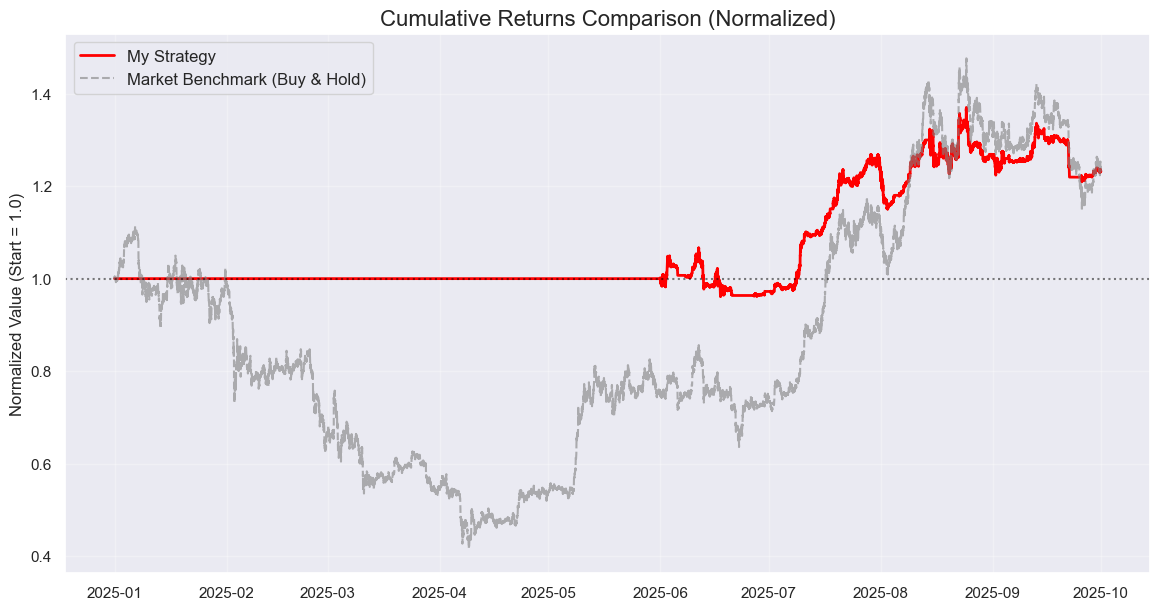

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# 1. 计算归一化净值 (从 1.0 开始)
# 策略净值 = 当前总资产 / 初始资金
strategy_curve = wallet['total_equity'] / wallet['total_equity'].iloc[0]

# 市场基准 = 当前价格 / 初始价格 (模拟全仓买入并持有)
market_curve = wallet['price'] / wallet['price'].iloc[0]

# 2. 绘图
plt.plot(strategy_curve.index, strategy_curve, label='My Strategy', color='red', linewidth=2)
plt.plot(market_curve.index, market_curve, label='Market Benchmark (Buy & Hold)', color='gray', alpha=0.6, linestyle='--')

# 3. 装饰
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5) # 盈亏平衡线
plt.title('Cumulative Returns Comparison (Normalized)', fontsize=16)
plt.ylabel('Normalized Value (Start = 1.0)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

- I made this function for only stocks. For cryptocurrency your buy amount or sell amount can be float.
- There is still error in bet sizing. This function calculate buy amount as *bet_size* * *initial_cash*. It should be *bet_size* * *cash_inventory*.

In [99]:
# eth_position = wallet.money_spent-wallet.money_receive
# cash_position = wallet.cash_inventory.diff()

In [ ]:
# positions = pd.DataFrame()
# positions['ETH'] = eth_position
# positions['cash'] = cash_position
# positions

In [119]:
ret = barrier_t.ret
ret

open_time
2025-06-01 00:30:00    0.026067
2025-06-01 00:45:00    0.028423
2025-06-01 01:00:00    0.032287
2025-06-01 02:15:00    0.041882
2025-06-01 02:30:00    0.040506
                         ...   
2025-09-27 22:00:00    0.033978
2025-09-27 22:15:00    0.029870
2025-09-27 22:45:00    0.028602
2025-09-27 23:00:00    0.025396
2025-09-27 23:45:00    0.030822
Name: ret, Length: 5840, dtype: float64

In [120]:
# import pyfolio as pf

# # 在 Notebook 中这样操作：
# wallet = tb.get_wallet_v2(close, barrier_t, initial_money=10000)

# # 1. 计算每日收益率 (必须使用复利 prod，不能用 sum)
# # wallet['returns'] 已经是小数格式 (0.01 表示 1%)，不要再除以 100
# daily_ret = (1 + wallet['returns']).resample('D').prod() - 1

# # 2. 准备 Pyfolio 要求的 Positions DataFrame
# # 它必须包含各资产市值和 'cash' 列
# daily_pos = pd.DataFrame({
#     'ETH': wallet['n_stock'] * wallet['price'], # ETH 持仓市值
#     'cash': wallet['cash_inventory']            # 现金余额
# })

# # 3. 持仓重采样：取每日最后时刻的状态 (不能用 sum)
# daily_pos_resampled = daily_pos.resample('D').last()

# # 4. 调用 Pyfolio
# import pyfolio as pf
# pf.create_full_tear_sheet(
#     returns=daily_ret, 
#     positions=daily_pos_resampled
# )

Start date,2025-01-01
End date,2025-06-27
Total months,8
,Backtest
Annual return,12.067%
Cumulative returns,8.38%
Annual volatility,34.97%
Sharpe ratio,0.50
Calmar ratio,0.29
Stability,0.35
Max drawdown,-42.022%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.02,2025-01-03,2025-04-08,2025-05-07,89
1,18.09,2025-06-09,2025-06-22,NaT,NaN
2,10.05,2025-05-13,2025-05-18,2025-05-26,10
3,7.48,2025-05-26,2025-06-05,2025-06-09,11
4,NaN,NaT,NaT,NaT,NaN


Top 10 long positions of all time,max
ETH,9069.46%


Top 10 short positions of all time,max
ETH,-190454.37%


Top 10 positions of all time,max
ETH,190454.37%


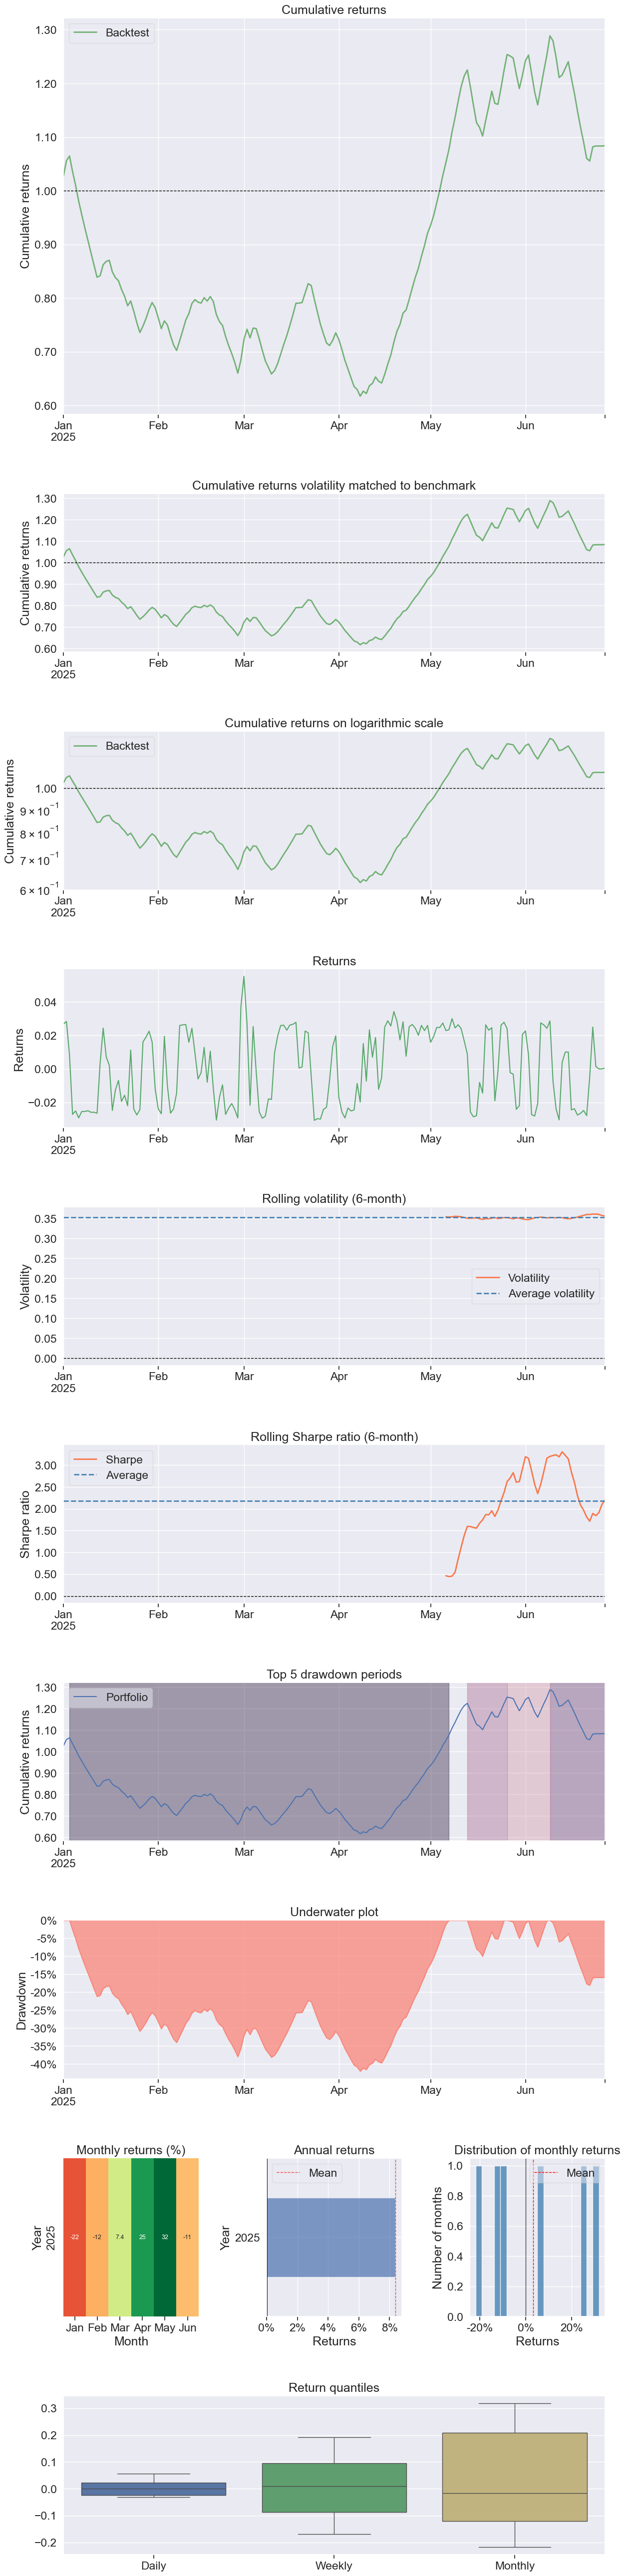

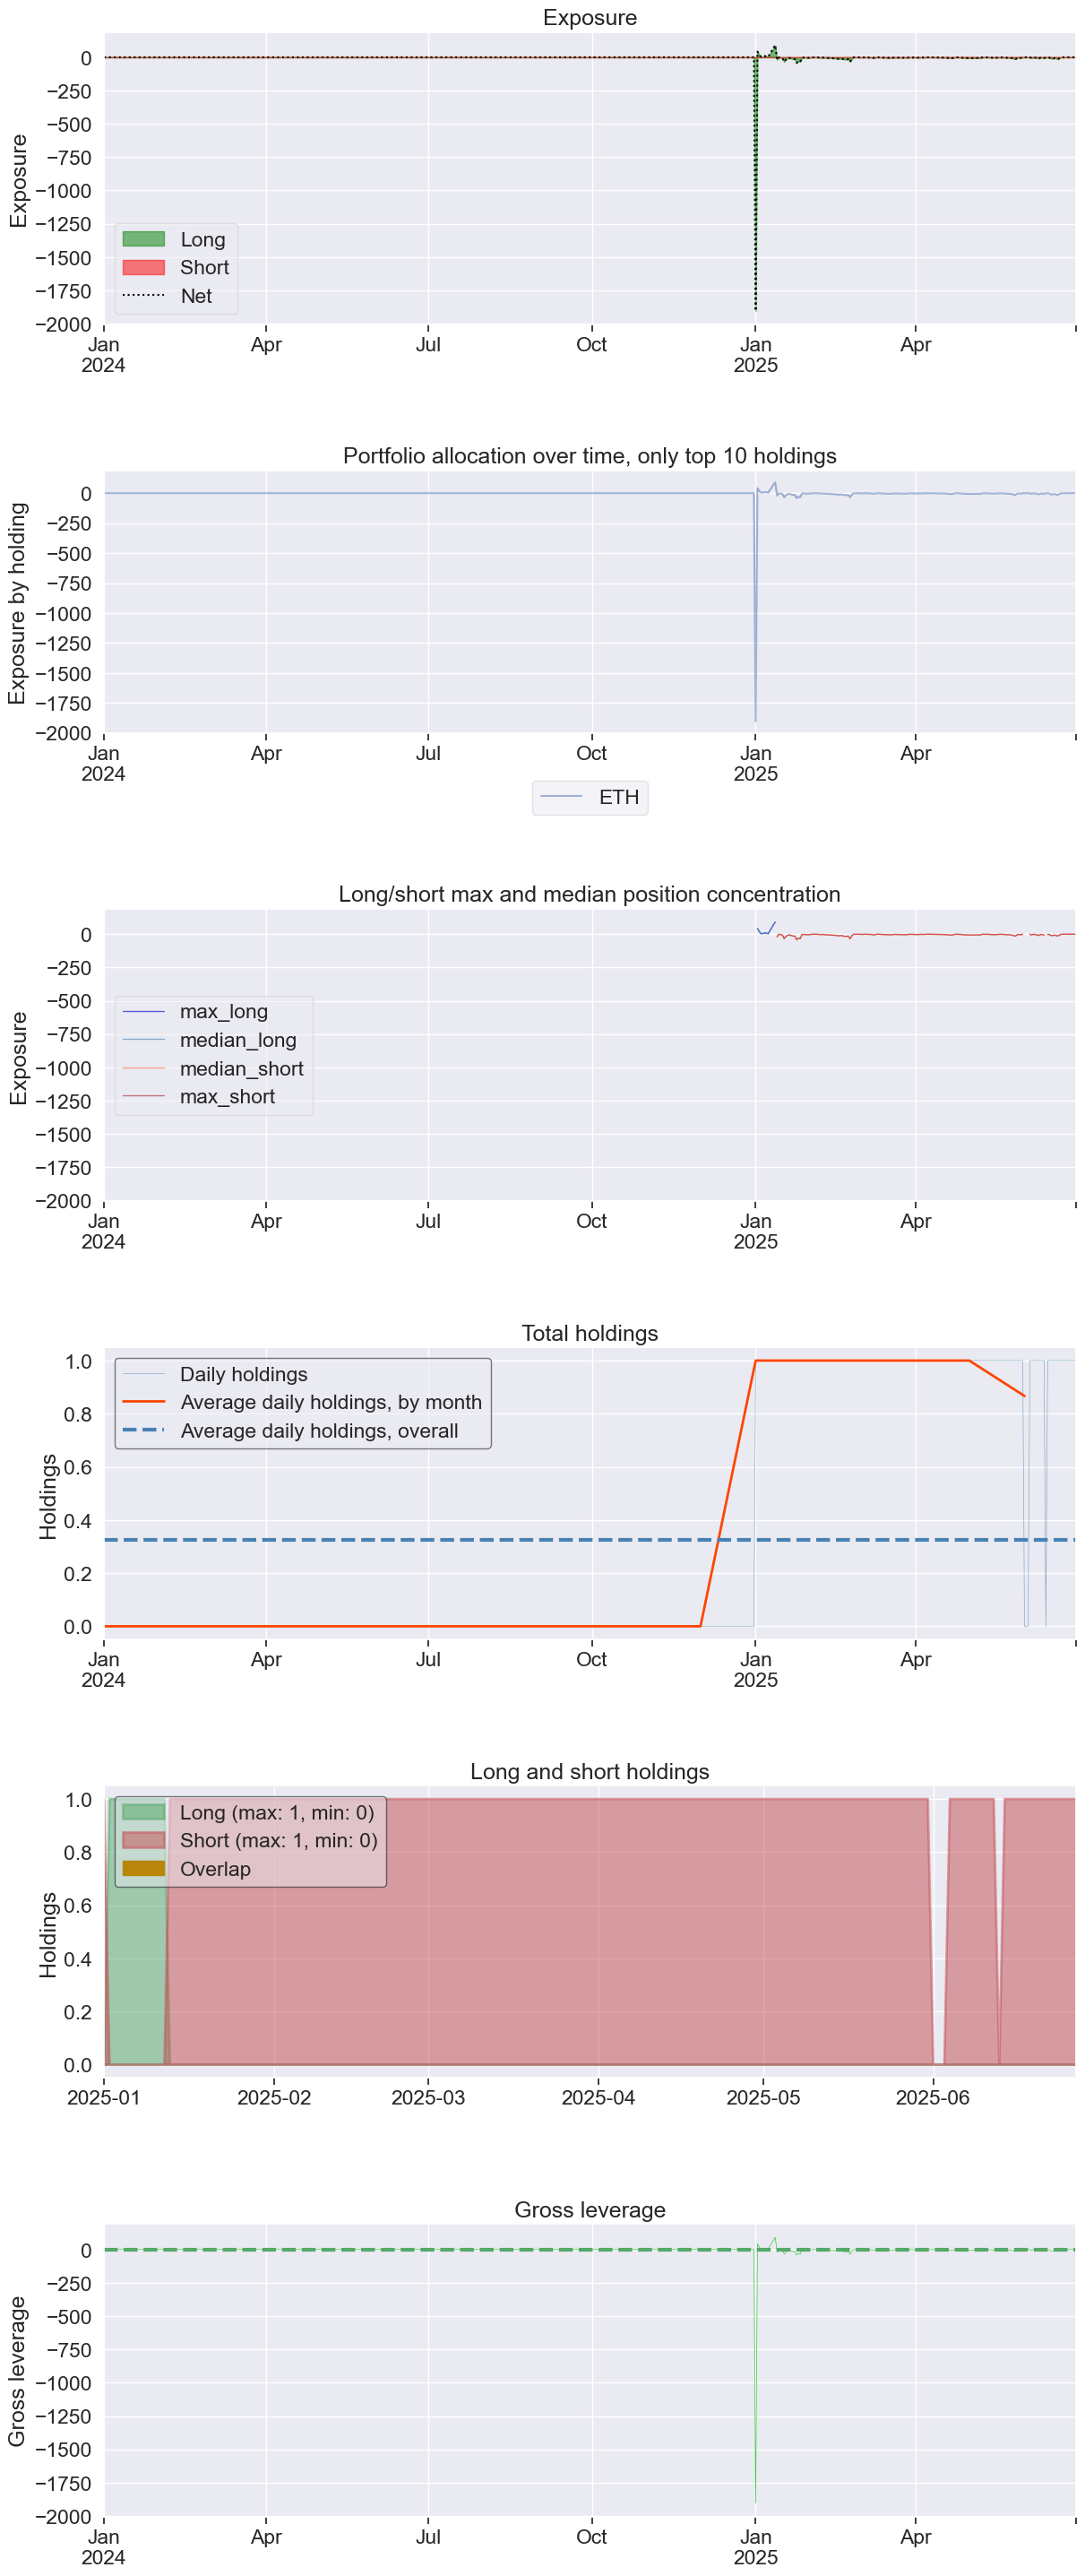

In [106]:
# # 1. 将百分比收益率转换为小数
# ret_daily = ret.resample('D').sum()
# positions_daily = positions.resample('D').sum()

# ret_pyfolio = ret_daily / 100.0

# # 2. 规范化持仓数据 (可选，但建议检查)
# # 确保 positions_daily 的最后一列是 'cash'，且总和代表了组合的总价值
# # 如果您只想看收益率分析，可以暂时不传 positions 参数
# # pf.create_full_tear_sheet(ret_pyfolio) 

# # 3. 正确的调用方式
# import pyfolio as pf

# pf.create_full_tear_sheet(
#     returns=ret_pyfolio, 
#     positions=positions_daily # 确保这里的单位与组合总价值一致
#     # periods_per_year=365       # 针对加密货币市场
# )

# Further Study

Feature Analysis: 
    - How to efficiently extract information from various market features using deep learning.